In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json

from rich import print
from python.analysis import Master, BeamParticleSelection, PFOSelection, Plots, shower_merging, vector, Tags, cross_section

import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from particle import Particle
from scipy.optimize import curve_fit


shower_merging.SetPlotStyle(extend_colors = True, dpi = 140)

In [2]:
config = "work/2023/cex_analysis_2GeV_confg.json"
if not config:
    mc = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP)
    data = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01.root", nTuple_type = Master.Ntuple_Type.PDSP)

    beam_quality_fits = {
        "mc" : "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03_fit_values.json",
        "data" : "work/2023/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01_fit_values.json"
    }
else:
    args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
    mc = Master.Data(args.mc_file, nTuple_type = Master.Ntuple_Type.PDSP)
    data = Master.Data(args.data_file, nTuple_type = Master.Ntuple_Type.PDSP)
    beam_quality_fits = {"mc" : args.mc_beam_quality_fit, "data" : args.data_beam_quality_fit}

samples = {"mc" : mc, "data": data}


for f in beam_quality_fits:
    with open(beam_quality_fits[f], "r") as file:
        beam_quality_fits[f] = json.load(file)

def FilterSamples(samples : dict, masks : dict, PFO : bool = False):
    for s in samples:
        if PFO:
            samples[s].Filter([masks[s]])
        else:
            samples[s].Filter([masks[s]], [masks[s]])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1126: RuntimeWarning: invalid value encountered in divide
  h_mc = np.sum(h_mc, axis = 0)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1127: RuntimeWarning: invalid value encountered in divide
  


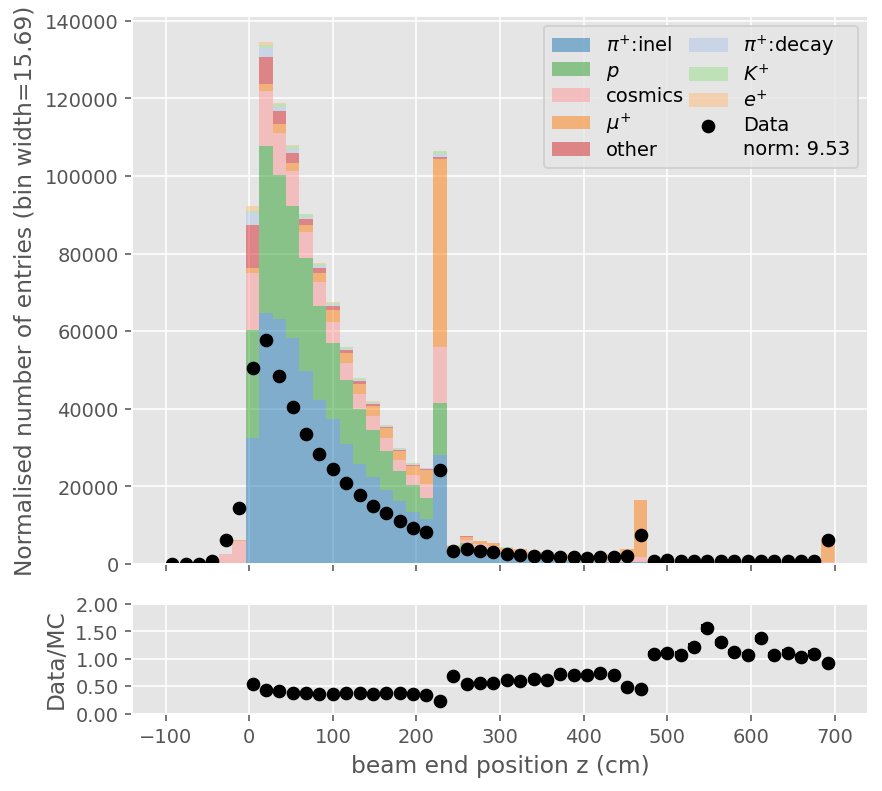

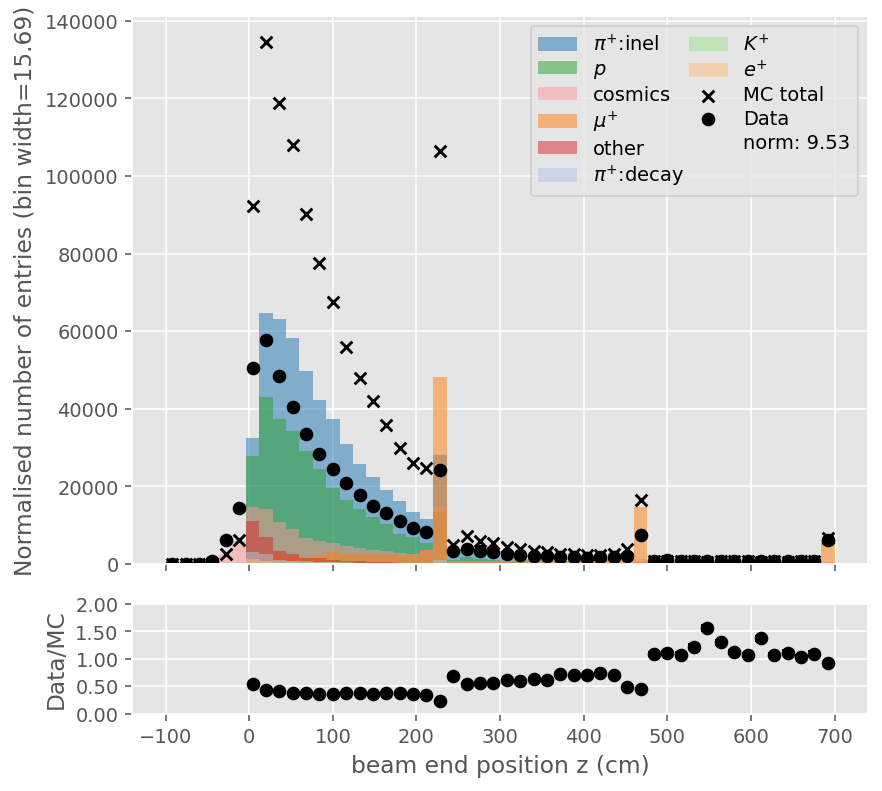

In [42]:
Plots.PlotTagged(mc.recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_endPos.z, x_range = [-100, 700], norm = True, bins = 50, x_label = "beam end position z (cm)", stacked = True, alpha = 0.5)
Plots.PlotTagged(mc.recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_endPos.z, x_range = [-100, 700], norm = True, bins = 50, x_label = "beam end position z (cm)", stacked = False, alpha = 0.5)
# Plots.PlotTagged(mc.trueParticles.endPos.z[:, 0], Tags.GenerateTrueBeamParticleTags(mc), x_range = [-100, 700], norm = True, bins = 50, x_label = "true beam end position z (cm)")

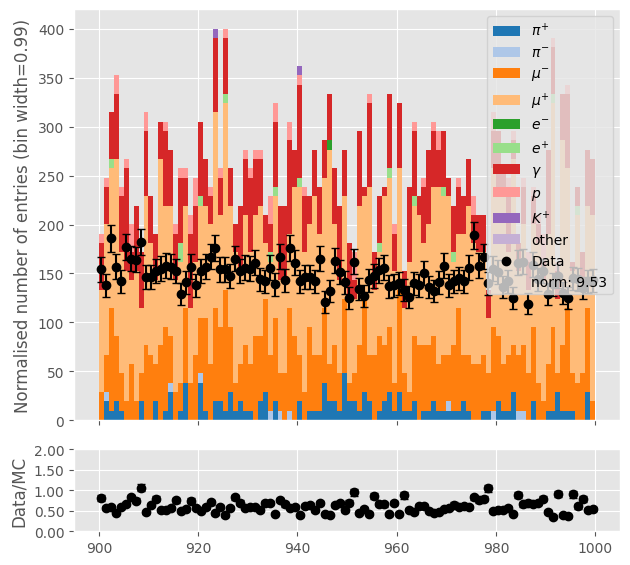

In [5]:
event_normalisation = ak.count(data.eventNum) / ak.count(mc.eventNum)
pfo_normalisation = ak.count(data.recoParticles.number) / ak.count(mc.recoParticles.number)
Plots.PlotTagged(mc.recoParticles.energy, Tags.GenerateTrueParticleTags(mc), data2 = data.recoParticles.energy, y_scale = "linear", norm = event_normalisation, x_range = [900, 1000])

# Beam Particle Selection

number of entries before|after PiBeamSelection: 141548|102443
number of entries before|after PiBeamSelection: 1349399|285238


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


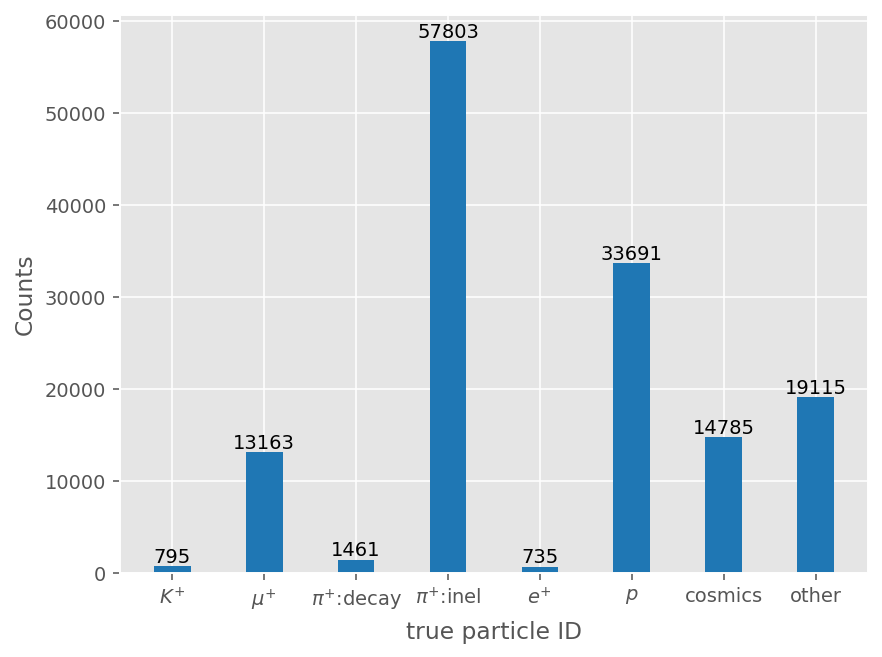

In [3]:
masks = {
    "mc" : BeamParticleSelection.PiBeamSelection(samples["mc"]),
    "data" : BeamParticleSelection.PiBeamSelection(samples["data"], use_beam_inst = True)
}

counts = Tags.GenerateTrueBeamParticleTags(samples["mc"])
for i in counts:
    counts[i] = ak.sum(counts[i].mask)

bar_data = []
for tag in counts:
    bar_data.extend([tag]*counts[tag])
Plots.PlotBar(bar_data, xlabel = "true particle ID")

FilterSamples(samples, masks)

In [4]:
masks = {s : BeamParticleSelection.CaloSizeCut(samples[s]) for s in samples}
FilterSamples(samples, masks)

number of entries before|after CaloSizeCut: 102443|91248
number of entries before|after CaloSizeCut: 285238|248398


number of entries before|after PandoraTagCut: 91248|87403
number of entries before|after PandoraTagCut: 248398|232423


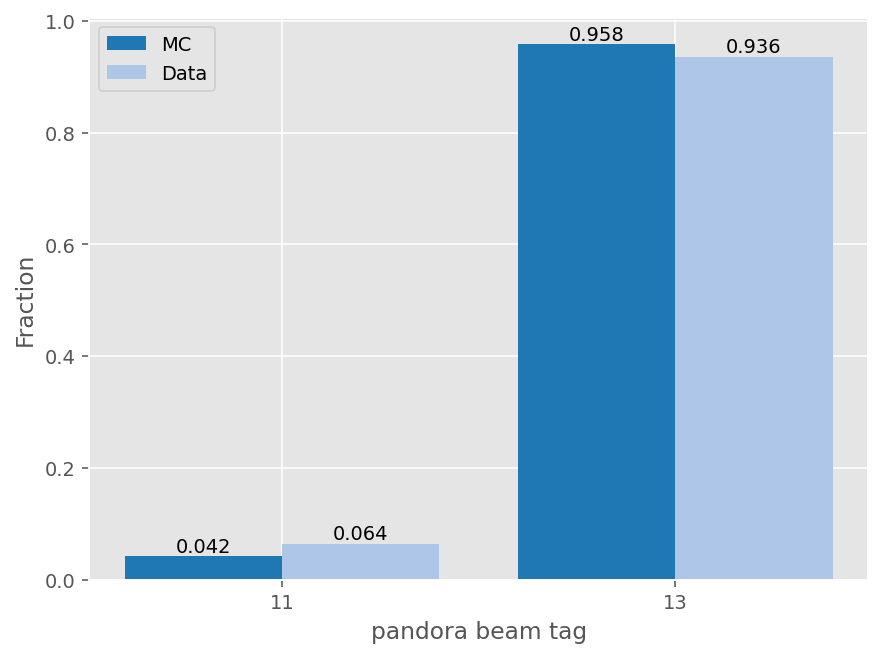

In [5]:
masks = {s : BeamParticleSelection.PandoraTagCut(samples[s]) for s in samples}

if data is None:
    Plots.PlotBar(samples["mc"])
else:
    Plots.PlotBarComparision(samples["mc"].recoParticles.beam_pandora_tag, samples["data"].recoParticles.beam_pandora_tag, label_1 = "MC", label_2 = "Data", xlabel = "pandora beam tag", fraction = True, barlabel = True)

FilterSamples(samples, masks)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1052: RuntimeWarning: divide by zero encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1053: RuntimeWarning: divide by zero encountered in divide
  ratio_err = ((h_data + p_err) / h_mc) - ratio
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1053: RuntimeWarning: invalid value encountered in subtract
  ratio_err = ((h_data + p_err) / h_mc) - ratio
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1052: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1053: RuntimeWarning: invalid value encountered in divide
  ratio_err = ((h_data + p_err) / h_mc) - ratio


dxy cut: (87403, 67615)

dxy cut: (232423, 180937)

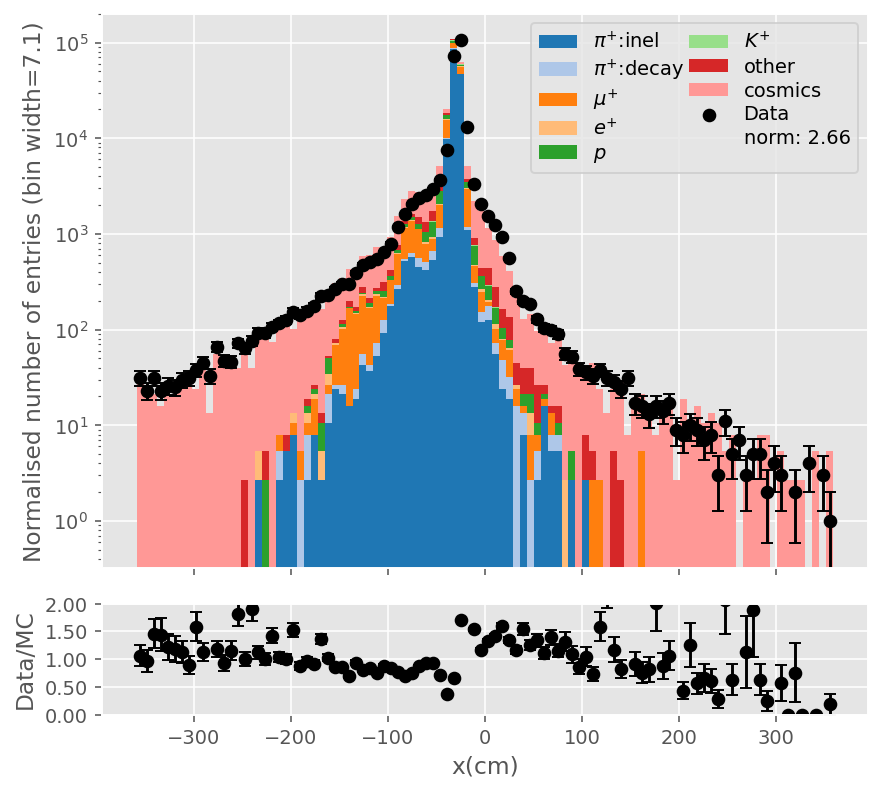

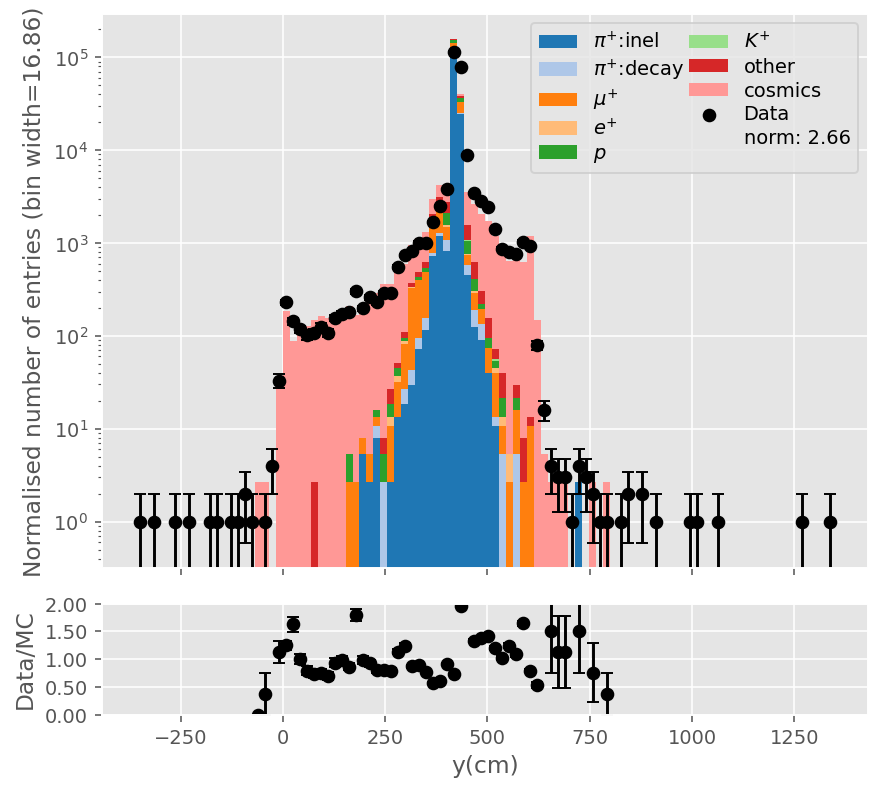

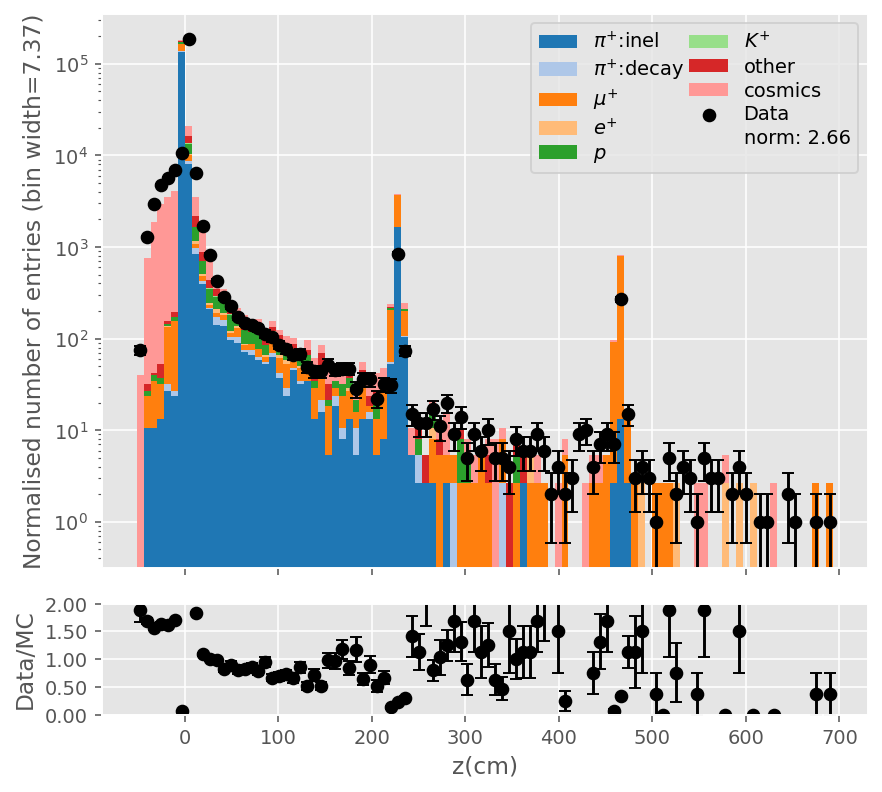

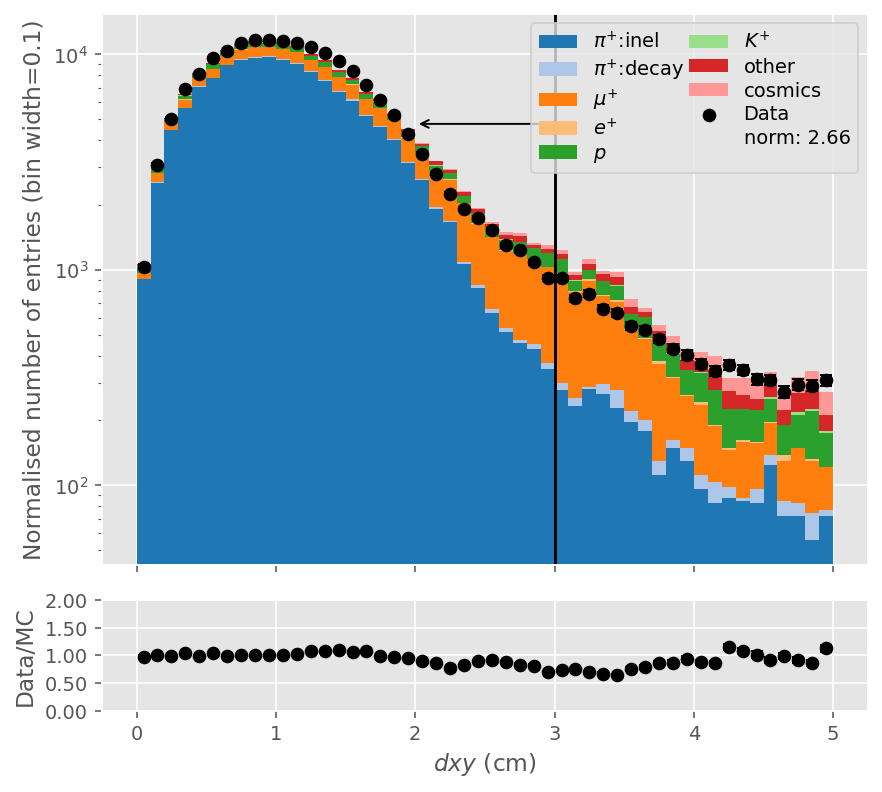

In [6]:
def norm(x, mu, sigma):
    return (x - mu) / sigma

# Beam quality cuts
for i in ["x", "y", "z"]:
    Plots.PlotTagged(mc.recoParticles.beam_startPos[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_startPos[i], x_label = i + "(cm)", y_scale = "log", norm = True)

#* dxy cut
dxy = {s : (norm(samples[s].recoParticles.beam_startPos.x, beam_quality_fits[s]["mu_x"], beam_quality_fits[s]["sigma_x"])**2 + norm(samples[s].recoParticles.beam_startPos.y, beam_quality_fits[s]["mu_y"], beam_quality_fits[s]["sigma_y"])**2)**0.5 for s in samples}
masks = {s : dxy[s] < 3 for s in samples}

Plots.PlotTagged(dxy["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(dxy["data"]), bins = 50, x_label = "$dxy$ (cm)", y_scale = "log", x_range = [0, 5], norm = True)
Plots.DrawCutPosition(3, arrow_length = 1, face = "left")

[print(f"dxy cut: {BeamParticleSelection.CountMask(masks[s])}") for s in masks]
FilterSamples(samples, masks)


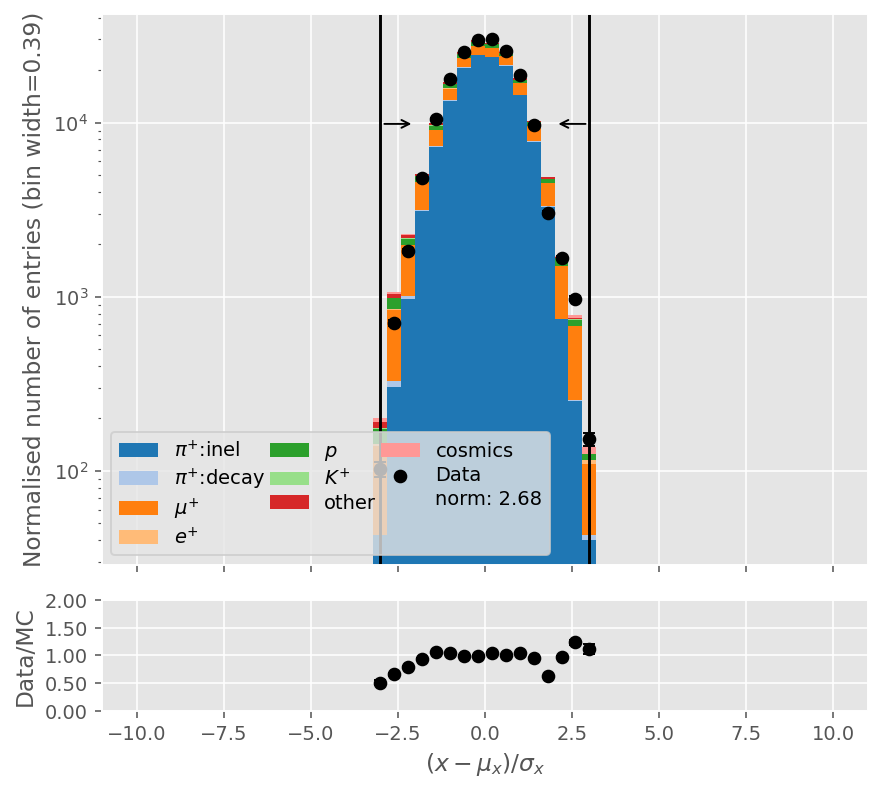

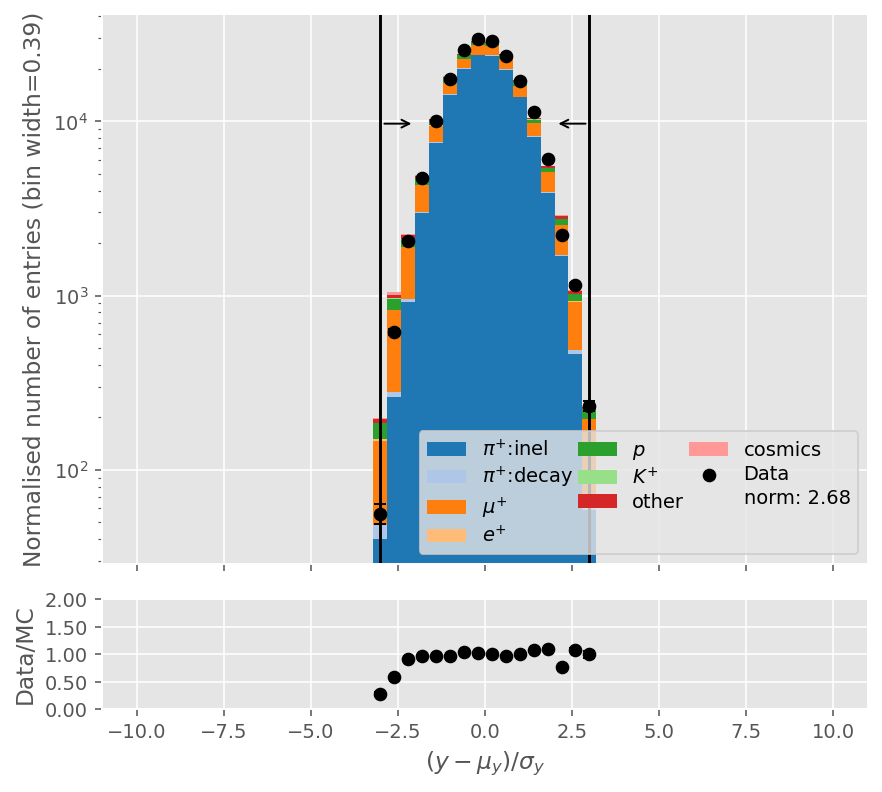

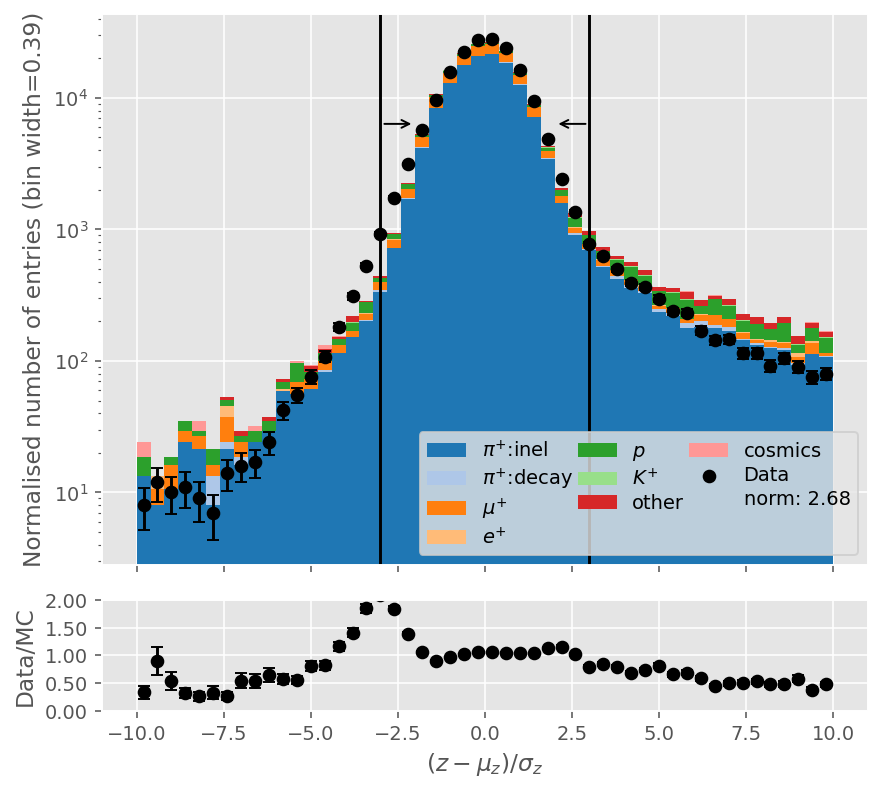

In [7]:
deltas_mc = {}
deltas_data = {}
for i in ["x", "y", "z"]:
    deltas_mc[i] = norm(samples["mc"].recoParticles.beam_startPos[i], beam_quality_fits["mc"][f"mu_{i}"], beam_quality_fits["mc"][f"sigma_{i}"])
    deltas_data[i] = norm(samples["data"].recoParticles.beam_startPos[i], beam_quality_fits["data"][f"mu_{i}"], beam_quality_fits["data"][f"sigma_{i}"])
    Plots.PlotTagged(deltas_mc[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(deltas_data[i]), bins = 50, x_range = [-10, 10], y_scale = "log", x_label = f"$(" + i + "- \mu_{"+ i + "} )/ \sigma_{" + i + "}$", ncols = 3, norm = True)
    Plots.DrawCutPosition(-3, arrow_length = 1, face = "right")
    Plots.DrawCutPosition(3, arrow_length = 1, face = "left")


masks = {
    "mc" : (deltas_mc["z"] > -3) & (deltas_mc["z"] < 3),
    "data" : (deltas_data["z"] > -3) & (deltas_data["z"] < 3)
}

FilterSamples(samples, masks)

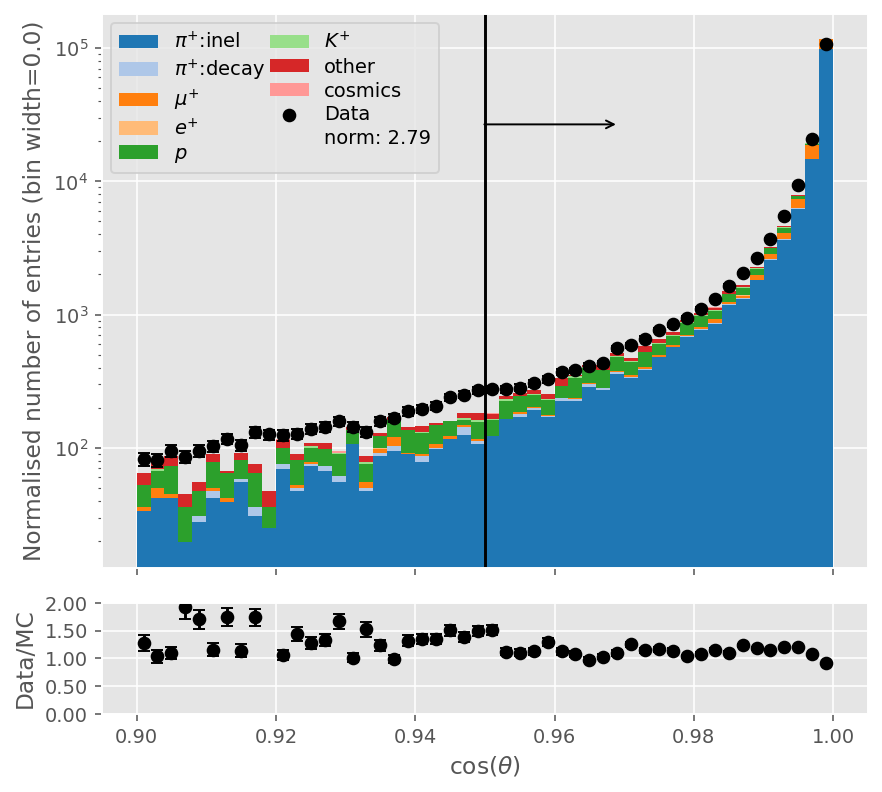

In [8]:
beam_dir = {s : vector.normalize(vector.sub(samples[s].recoParticles.beam_endPos, samples[s].recoParticles.beam_startPos)) for s in samples}

beam_dir_mu = {s : vector.normalize(vector.vector(beam_quality_fits[s]["mu_dir_x"], beam_quality_fits[s]["mu_dir_y"], beam_quality_fits[s]["mu_dir_z"])) for s in beam_quality_fits}

beam_costh = {s : vector.dot(beam_dir[s], beam_dir_mu[s]) for s in beam_dir_mu}

Plots.PlotTagged(beam_costh["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(beam_costh["data"]), x_label = "$\cos(\\theta)$", y_scale = "log", bins = 50, x_range = [0.9, 1], norm = True)
Plots.DrawCutPosition(0.95, arrow_length = 0.02)

masks = {s : beam_costh[s] > 0.95 for s in samples}
FilterSamples(samples, masks)

number of entries before|after APA3Cut: 59535|48560
number of entries before|after APA3Cut: 161779|123853


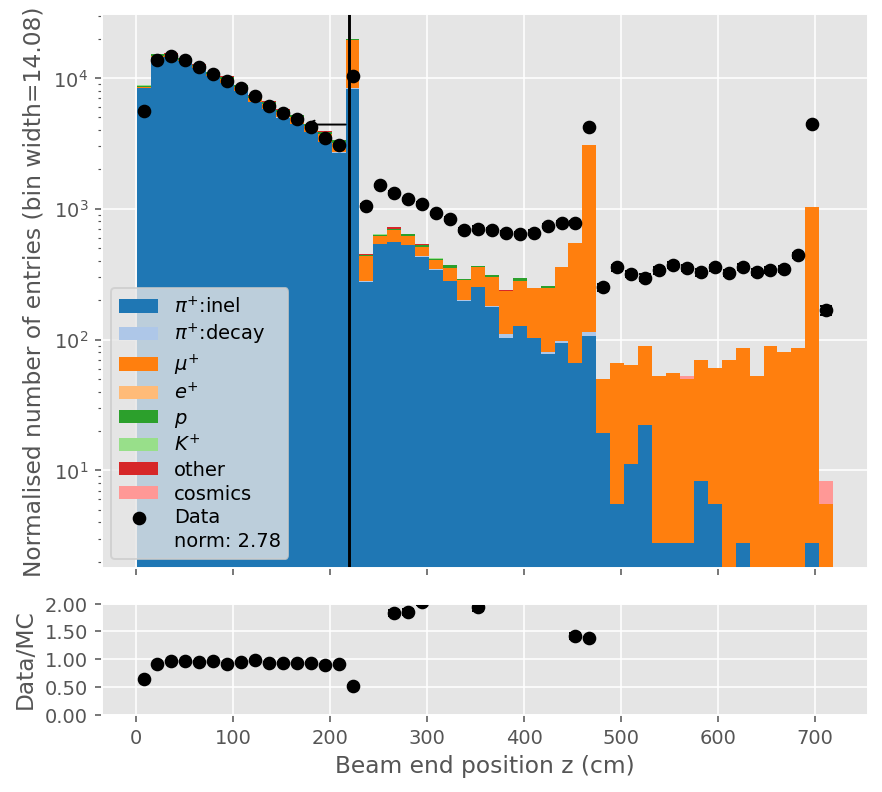

In [9]:
Plots.PlotTagged(samples["mc"].recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.beam_endPos.z, x_label = "Beam end position z (cm)", norm = args.norm, bins = 50, y_scale = "log", ncols = 1)
Plots.DrawCutPosition(220, face = "left", arrow_length = 50)

masks = {s : BeamParticleSelection.APA3Cut(samples[s]) for s in samples}

# FilterSamples(samples, masks)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 59535|54387
number of entries before|after MichelScoreCut: 161779|155524


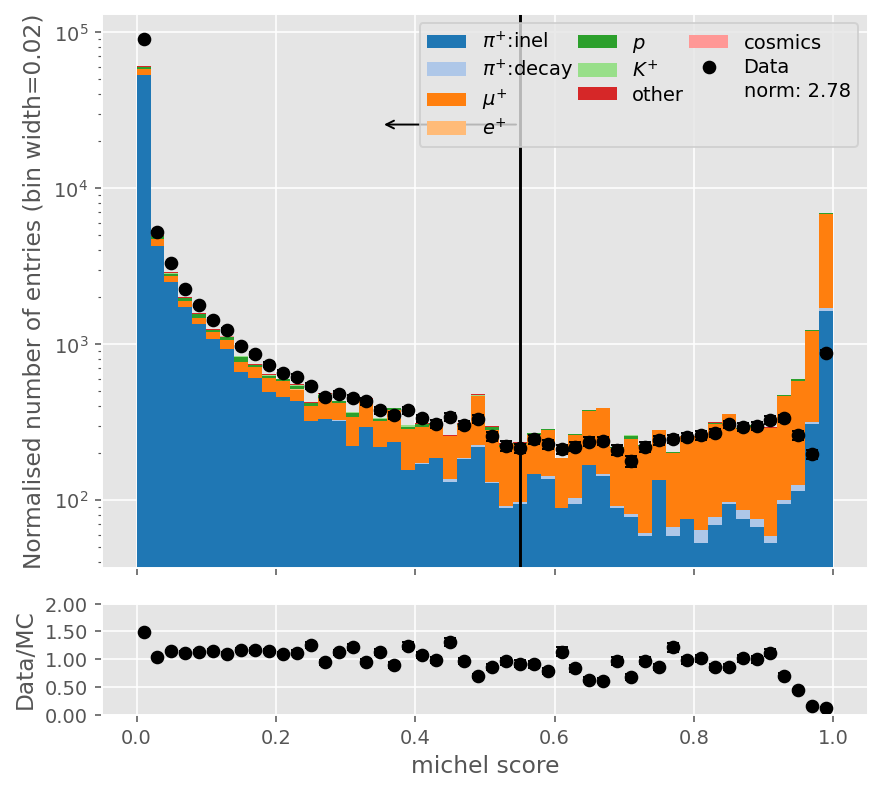

In [10]:
# michel score cut

scores = {}
for s in samples:
    score = ak.where(samples[s].recoParticles.beam_nHits != 0, samples[s].recoParticles.beam_michelScore / samples[s].recoParticles.beam_nHits, -999)
    masks[s] = BeamParticleSelection.MichelScoreCut(samples[s])
    scores[s] = score

Plots.PlotTagged(scores["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = np.array(scores["data"]), x_range = (0, 1), y_scale = "log", bins = 50, x_label = "michel score", ncols = 3, norm = args.norm)
Plots.DrawCutPosition(0.55, face = "left")

# FilterSamples(samples, masks)

number of entries before|after MedianDEdXCut: 46519|46519
number of entries before|after MedianDEdXCut: 117240|117240


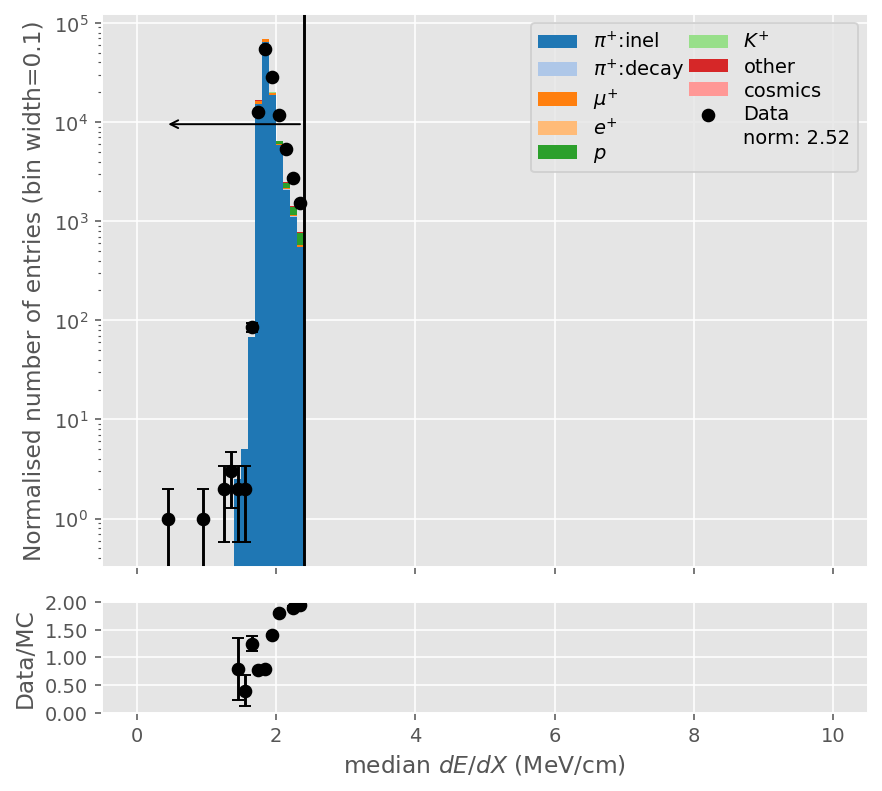

In [14]:
median = {s : PFOSelection.Median(samples[s].recoParticles.beam_dEdX) for s in samples}

Plots.PlotTagged(median["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = median["data"], y_scale = "log", x_range = [0, 10], x_label = "median $dE/dX$ (MeV/cm)", norm = True)
Plots.DrawCutPosition(2.4, face = "left", arrow_length = 2)

masks = {s : BeamParticleSelection.MedianDEdXCut(samples[s]) for s in samples}
FilterSamples(samples, masks)

In [4]:
# nutples do not contain truth information about whether a beam particle is scaper or not
# This is done in the PDSPAnalyser by checking if the true particle passes through the A1 ring in the plug
# done by looping over all trajectory points, and comparing the geometry material type to the A1 ring ("ALUMINUM_Al"), if it did not pass through the A1 ring it is a beam scraper.
# https://github.com/DUNE/protoduneana/blob/2b58725d6de7befa6ebd098c701bd75742fd8b6e/protoduneana/singlephase/Analysis/PDSPAnalyzer_module.cc#L3989

# Plots.PlotHist2D(mc.recoParticles.beam_startPos.x, mc.recoParticles.beam_startPos.y)
# print(mc.io.ListNTuples("true_beam_traj_KE"))

def KE(p, m):
    return np.sqrt(p**2 + m**2) - m

# if not hasattr(mc.trueParticles, "_TrueParticleData__true_beam_traj_KE"): mc.trueParticles.LoadData("true_beam_traj_KE", "true_beam_traj_KE")
# if not hasattr(mc.recoParticles, "_RecoParticleData__beam_inst_P"): mc.recoParticles.LoadData("beam_inst_P", "beam_inst_P")
# if not hasattr(mc.recoParticles, "_RecoParticleData__reco_beam_inst_pos"): mc.recoParticles.LoadData("reco_beam_inst_pos", ["beam_inst_X", "beam_inst_Y", "beam_inst_Z"], is_vector = True)
# if not hasattr(mc.recoParticles, "_RecoParticleData__reco_beam_calo_pos"): mc.recoParticles.LoadData("reco_beam_calo_pos", ["reco_beam_calo_X", "reco_beam_calo_Y", "reco_beam_calo_Z"], is_vector = True)
# if not hasattr(mc.trueParticles, "_TrueParticleData__true_beam_traj_pos"): mc.trueParticles.LoadData("true_beam_traj_pos", ["true_beam_traj_X_SCE", "true_beam_traj_Y_SCE", "true_beam_traj_Z_SCE"], is_vector = True)

mc.target_mom = 2
beam_inst_p = mc.recoParticles.beam_inst_P
beam_inst_KE = KE(beam_inst_p, Particle.from_pdgid(211).mass)

In [5]:
def GetTrueFFKE(KE_tpc, length_to_ff):
    """ True Front facing kinetic energy is the kinetic energy of the first particle trajectory point in the tpc,
        plus the energy lost between the first trajectory point in the TPC and trajectory point before.

    Args:
        KE_tpc (ak.Array): kinetic energy at the first trajectory point in the TPC
        length_to_ff (ak.Array): distance from first trajectory point in the TPC and the one before it. idea is to use this as an approximation of the distance to the front face of the TPC

    Returns:
        ak.Array: true kinetic energy at the front face of the TPC
    """
    dEdX = cross_section.BetheBloch.meandEdX(KE_tpc, Particle.from_pdgid(211))
    return KE_tpc + dEdX * length_to_ff

print((mc.trueParticles.beam_traj_pos.z < 0)[::-1])
print(mc.trueParticles.beam_traj_pos.z)

true_ff_ind = ak.num(mc.trueParticles.beam_traj_pos.z) - ak.argmax((mc.trueParticles.beam_traj_pos.z < 0)[:, ::-1], -1) - 1
reco_ff_ind = ak.num(mc.recoParticles.beam_calo_pos.z) - ak.argmax((mc.recoParticles.beam_calo_pos.z < 0)[:, ::-1], -1) - 1

def dist_into_tpc(arr : ak.Array, ind : int) -> ak.Array:
    """ Calculates the distance between the trajectory point after ind and ind. Required for akward arrays

    Args:
        arr (ak.Array): trajectory points
        ind (int): index of point which is just before the TPC

    Returns:
        any: distance between points
    """
    outside_tpc = arr[ind]
    if ind + 1 >= ak.count(arr):
        ff_tpc = outside_tpc
    else:
        ff_tpc = arr[ind + 1]
    return ff_tpc - outside_tpc


def ff_value(arr : ak.Array, ind : int):
    """ returns a quantity of any trajectory point at the first trajectory point in the TPC.

    Args:
        arr (ak.Array): values
        ind (int): index to return value at

    Returns:
        any: value at ind
    """
    if ind + 1 >= ak.count(arr):
        return arr[ind]
    else:
        return arr[ind + 1]
    

pitches = vector.vector(**{i : ak.Array(map(dist_into_tpc, mc.trueParticles.beam_traj_pos[i], true_ff_ind)) for i in ["x", "y", "z"]})
pitches = vector.magnitude(pitches)
print(pitches)

first_KE = ak.Array(map(ff_value, mc.trueParticles.beam_traj_KE, true_ff_ind))
reco_first_traj_pos = vector.vector(**{i : ak.Array(map(ff_value, mc.recoParticles.beam_calo_pos[i], reco_ff_ind)) for i in ["x", "y", "z"]})

print(first_KE)
true_ffKE = GetTrueFFKE(first_KE, pitches)

[[True, True, True, True, True, True, ... False, False, False, False, False, False]]

[[-130, -108, -98.9, -48.9, -48.8, -47.8, -47.2, ... 99.6, 106, 113, 119, 126, 126]]

[55.9, 57.7, 74.1, 70, 54.4, 51.9, 64.3, ... 63.3, 71.7, 62.8, 54.8, 60.4, 58.6]

[1.96e+03, 1.84e+03, 1.92e+03, 1.88e+03, ... 1.94e+03, 2.08e+03, 1.98e+03, 1.73e+03]

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in multiply
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in add
  result = getattr(ufunc, method)(


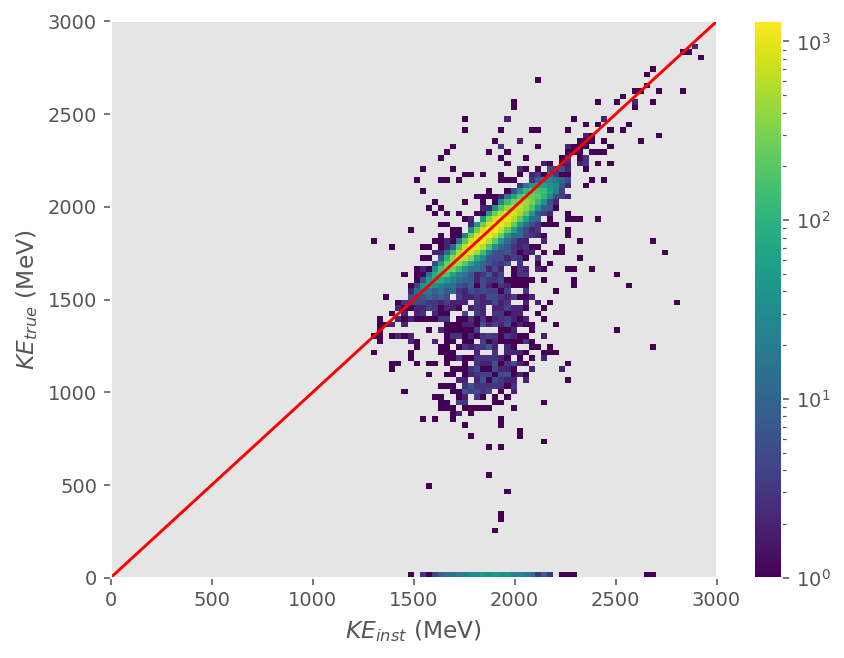

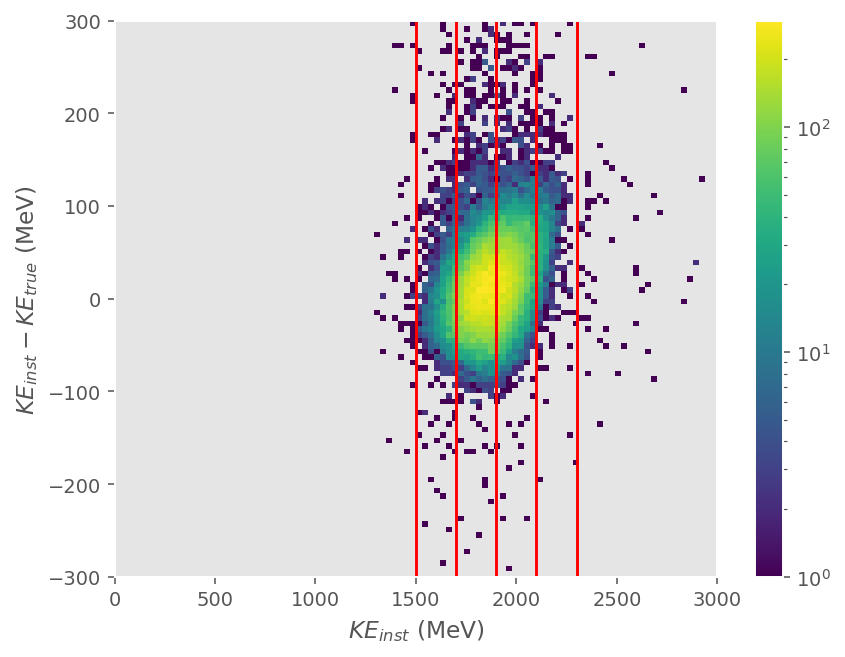

In [15]:
energy_range = [0, 3000]
residual_range = [-300, 300]
beam_inst_KE_bins = [1500, 1700, 1900, 2100, 2300]

bins = 100
multiplicity = 1.5

Plots.Plot(energy_range, energy_range, color = "red")
Plots.PlotHist2D(beam_inst_KE, true_ffKE, xlabel = "$KE_{inst}$ (MeV)", ylabel = "$KE_{true}$ (MeV)", x_range = energy_range, y_range = energy_range, newFigure = False)

delta_KE_upstream = beam_inst_KE - true_ffKE
Plots.PlotHist2D(beam_inst_KE, delta_KE_upstream, xlabel = "$KE_{inst}$ (MeV)", ylabel = "$KE_{inst} - KE_{true}$ (MeV)", x_range = energy_range, y_range = residual_range)
for i in beam_inst_KE_bins: plt.axvline(i, color = "red")


[ 33.75023134 -13.28457788  35.60610075] [[ 0.79806116  0.26289245 -0.92436068]
 [ 0.26289245  2.71065013 -1.85950508]
 [-0.92436068 -1.85950508  3.46591938]]

[249.33090807   5.02693628 -36.29845204] [[4.92132108 0.0715901  0.85031617]
 [0.0715901  0.16972015 0.0440809 ]
 [0.85031617 0.0440809  0.3439433 ]]

[192.42332682  23.15113307  39.60097507] [[ 3.74152797  0.05636776 -0.88977874]
 [ 0.05636776  0.24906143 -0.04741968]
 [-0.88977874 -0.04741968  0.49592905]]

[16.47012876 63.38690552 36.01134903] [[ 0.27533606  0.07197187 -0.55141323]
 [ 0.07197187  2.00241608 -0.54702329]
 [-0.55141323 -0.54702329  2.8730755 ]]

-29.606390407884216

422.2107357089667

3.277667894881598

3.0858349472173665

[-13.284577877844656, 5.026936281381455, 23.15113307177365, 63.38690551937552]

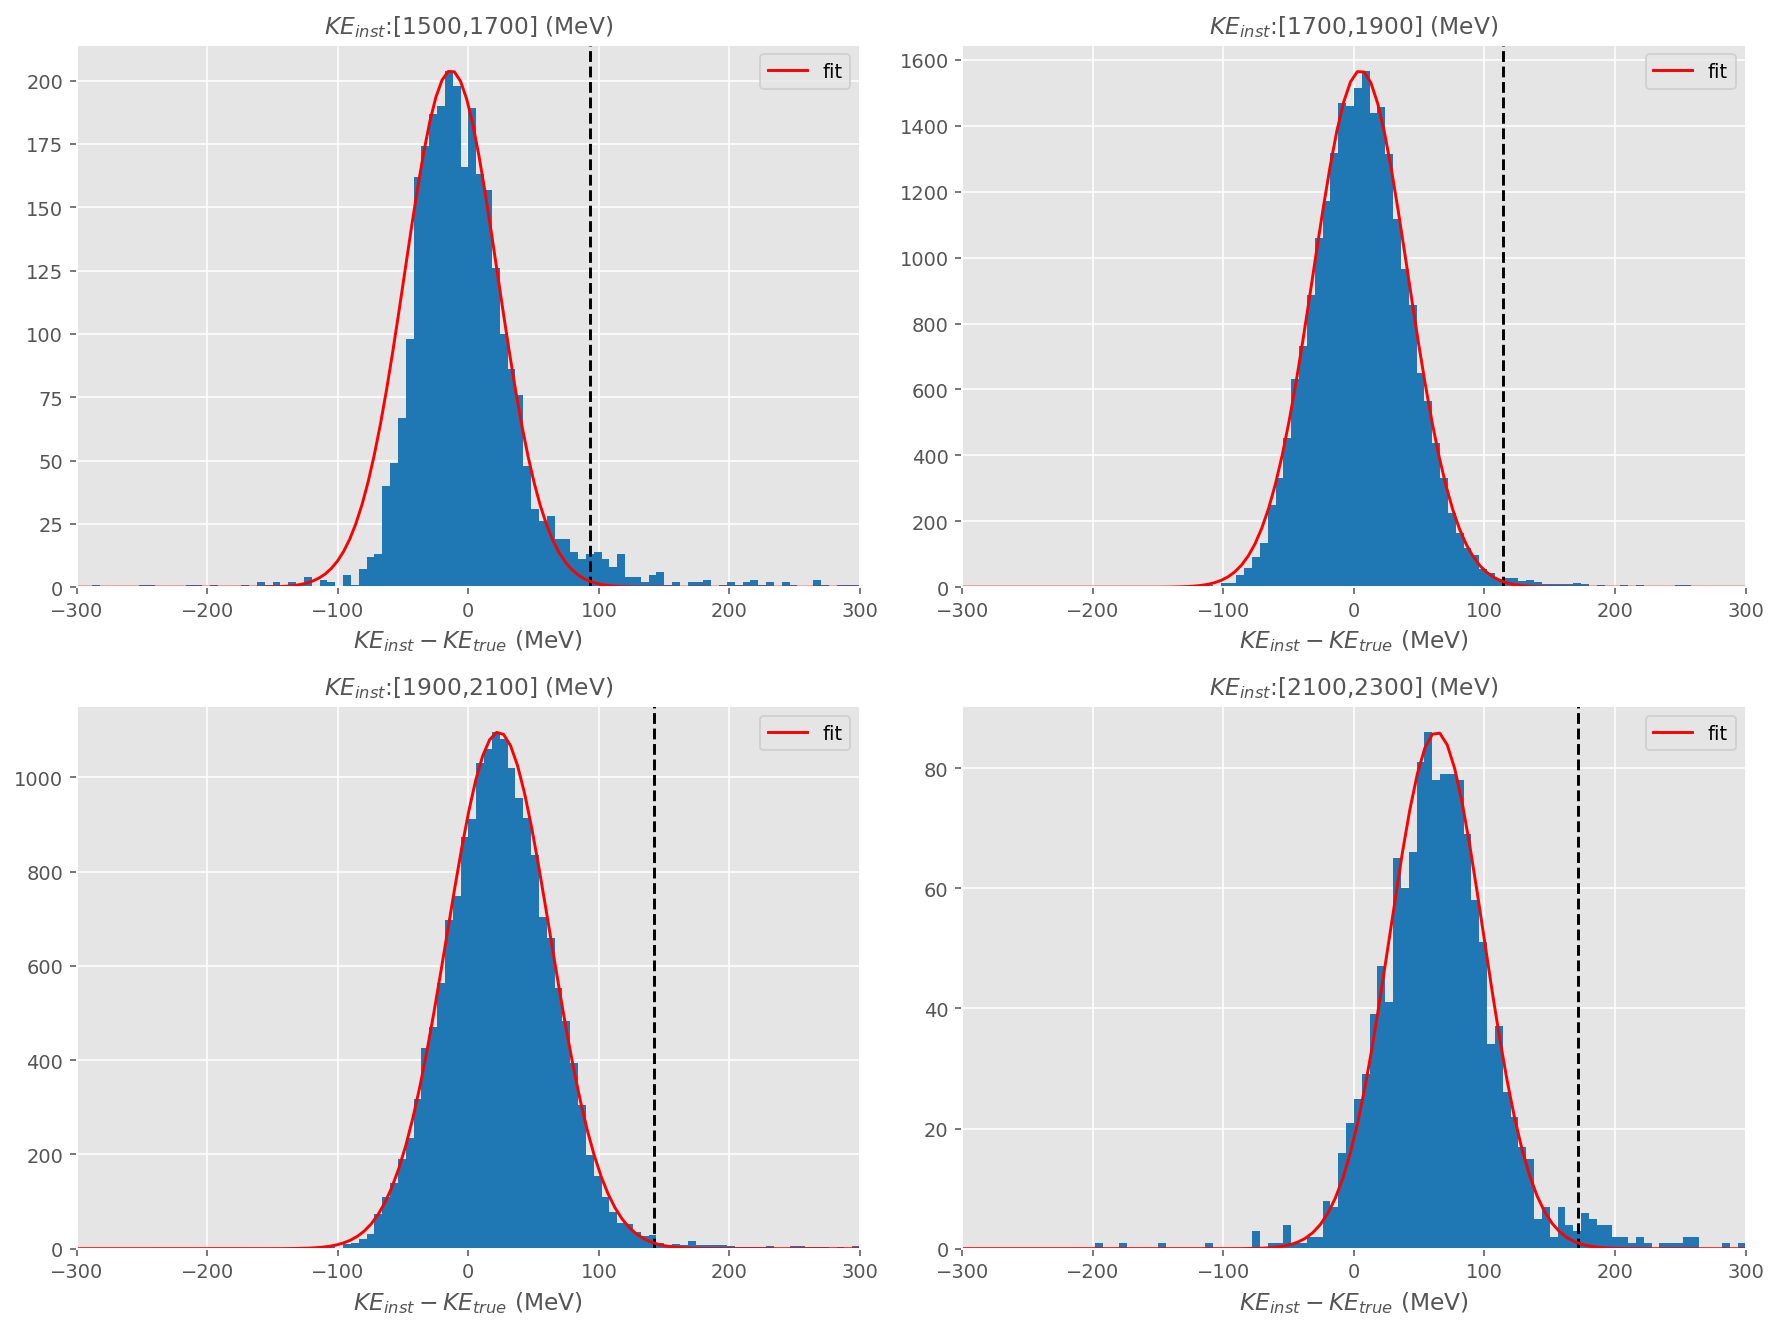

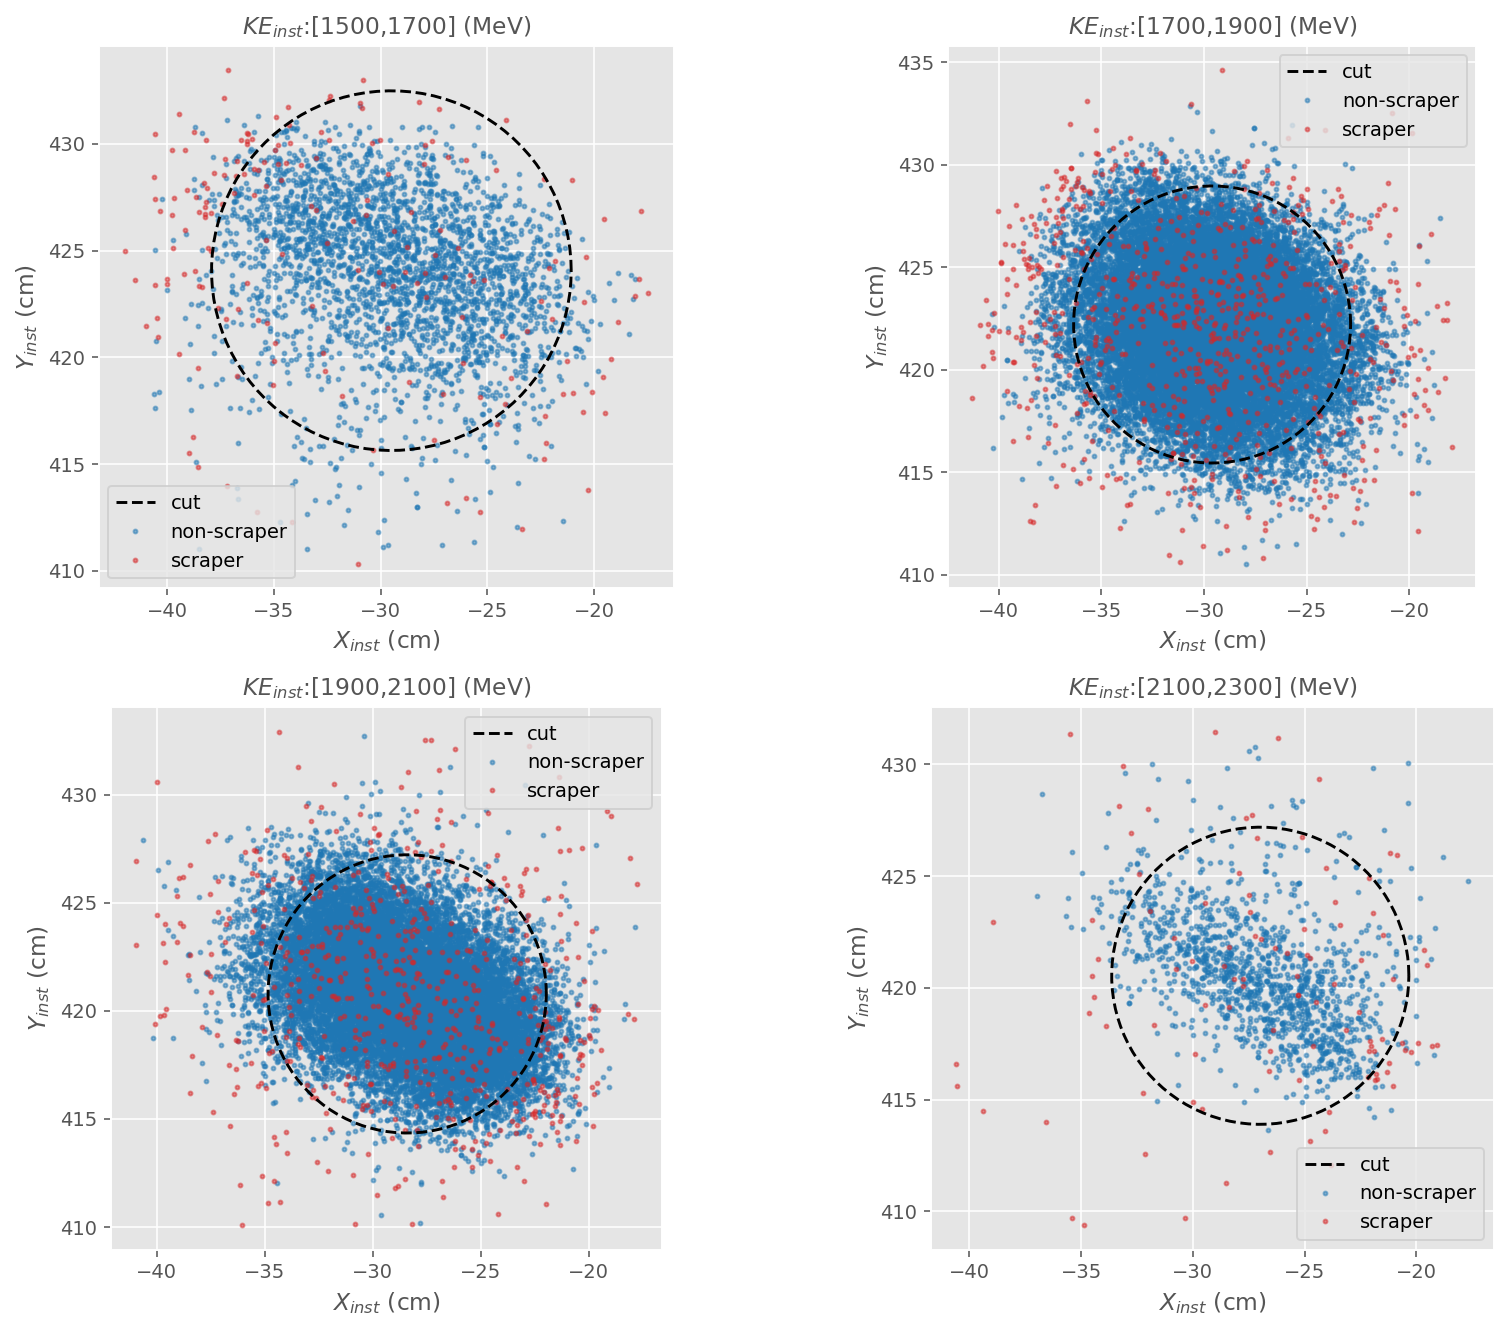

In [16]:
plt.subplots(2, 2, figsize = [6.4 * 2, 4.8 * 2], num = 1)
plt.gcf().set_size_inches(6.4 * 2, 4.8 * 2)

plt.subplots(2, 2, figsize = [6.4 * 2, 4.8 * 2], num = 2)
plt.gcf().set_size_inches(6.4 * 2, 4.8 * 2)

mean_x = []
mean_y = []
std_x = []
std_y = []

scraper_threshold = []

for i in range(1, len(beam_inst_KE_bins)):
    bin_label = "$KE_{inst}$:" + f"[{beam_inst_KE_bins[i-1]},{beam_inst_KE_bins[i]}] (MeV)"
    e = (beam_inst_KE < beam_inst_KE_bins[i]) & (beam_inst_KE > beam_inst_KE_bins[i-1])

    popt, pcov = cross_section.Fit_Gaussian(delta_KE_upstream[e], bins)
    print(popt, pcov)

    plt.figure(1)
    plt.subplot(2, 2, i)
    heights, edges = Plots.PlotHist(delta_KE_upstream[e], newFigure = False, bins = bins, range = residual_range)

    x_interp = np.linspace(min(delta_KE_upstream[e]), max(delta_KE_upstream[e]), 5 * bins)
    y_interp = cross_section.Gaussian(x_interp, max(heights), popt[1], popt[2])
    Plots.Plot(x_interp, y_interp, color = "red", label = "fit", title = bin_label, xlabel = "$KE_{inst} - KE_{true}$ (MeV)", newFigure = False)
    plt.axvline(popt[1] + 3 * abs(popt[2]), color = "black", linestyle = "--")
    plt.xlim(*residual_range)

    scraper_threshold.append(popt[1])
    is_scraper = delta_KE_upstream[e] > (popt[1] + 3 * abs(popt[2]))

    plt.figure(2)
    plt.subplot(2, 2, i)
    Plots.Plot(mc.recoParticles.beam_inst_pos.x[e][~is_scraper], mc.recoParticles.beam_inst_pos.y[e][~is_scraper], newFigure = False, linestyle = "", marker = "o", markersize = 2, title = bin_label, color = "C0", alpha = 0.5, label = "non-scraper")
    Plots.Plot(mc.recoParticles.beam_inst_pos.x[e][is_scraper], mc.recoParticles.beam_inst_pos.y[e][is_scraper], newFigure = False, linestyle = "", marker = "o", markersize = 2, title = bin_label, color = "C6", alpha = 0.5, label = "scraper")
    plt.xlabel("$X_{inst}$ (cm)")
    plt.ylabel("$Y_{inst}$ (cm)")

    mu_x = ak.mean(mc.recoParticles.beam_inst_pos[e].x)
    mu_y = ak.mean(mc.recoParticles.beam_inst_pos[e].y)
    sigma_x = ak.std(mc.recoParticles.beam_inst_pos[e].x)
    sigma_y = ak.std(mc.recoParticles.beam_inst_pos[e].y)


    theta = np.linspace(0, 2*np.pi, 100)
    r = multiplicity * (sigma_x**2 + sigma_y**2)**0.5
    x = r*np.cos(theta) + mu_x
    y = r*np.sin(theta) + mu_y
    
    plt.plot(x, y, linestyle = "--", color = "black", label = "cut", zorder = 10)
    plt.axis('scaled')
    plt.legend()

    mean_x.append(mu_x)
    mean_y.append(mu_y)
    std_x.append(sigma_x)
    std_y.append(sigma_y)

print(mean_x[1])
print(mean_y[1])
print(std_x[1])
print(std_y[1])
print(scraper_threshold)


mu or sigma was not specified, manually calculating beam scraper cut values
[0.0549, 1.53, -0.555, 0.151, -0.469, -2.28, ... 0.767, 1.24, 0.241, 1.01, -0.273]
[-0.321, -1.01, 0.0951, -1.11, -1.25, ... -0.608, 0.199, 0.529, -0.319, 0.702]
number of entries before|after BeamScraper: 77632|57620


57620

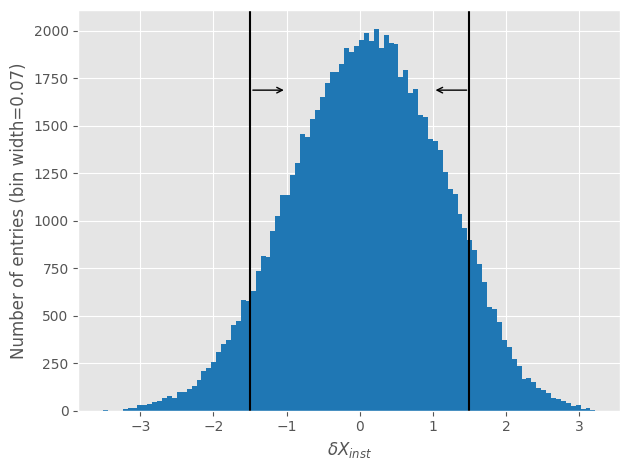

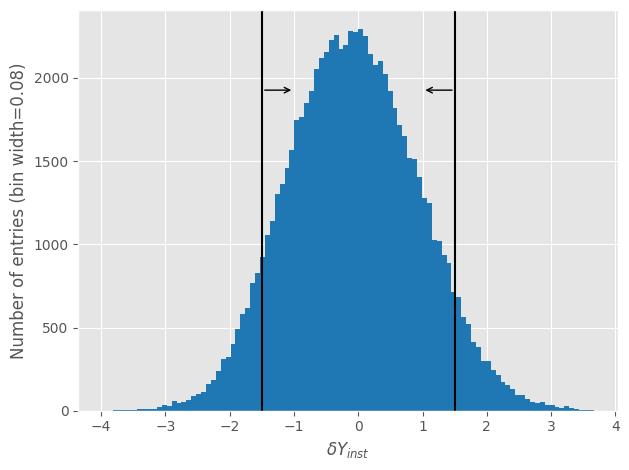

In [19]:
nx = norm(mc.recoParticles.beam_inst_pos.x, mean_x[1], std_x[1])
ny = norm(mc.recoParticles.beam_inst_pos.y, mean_y[1], std_y[1])

mc_mask = BeamParticleSelection.BeamScraper(mc, KE_range = [800, 900])

print(ak.sum(mc_mask))

r = (nx**2 + ny**2)**0.5
Plots.PlotHist(nx, xlabel = "$\delta X_{inst}$")
Plots.DrawCutPosition(-multiplicity, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(multiplicity, arrow_length = 0.5, face = "left")

Plots.PlotHist(ny, xlabel = "$\delta Y_{inst}$")
Plots.DrawCutPosition(-multiplicity, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(multiplicity, arrow_length = 0.5, face = "left")


In [3]:
masks = {}
masks["mc"] = BeamParticleSelection.CreateDefaultSelection(samples["mc"], False, beam_quality_fits["mc"], verbose = False, return_table = False)
masks["data"] = BeamParticleSelection.CreateDefaultSelection(samples["data"], True, beam_quality_fits["data"], verbose = False, return_table = False)
FilterSamples(samples, masks)

masks = {s : PFOSelection.GoodShowerSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after PiBeamSelection: 141548|102443
number of entries before|after PandoraTagCut: 141548|123438
number of entries before|after CaloSizeCut: 141548|125589


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 141548|115682
number of entries before|after BeamQualityCut: 141548|83800
number of entries before|after APA3Cut: 141548|121291
number of entries before|after MedianDEdXCut: 141548|131247
number of entries before|after PiBeamSelection: 1349399|285238
number of entries before|after PandoraTagCut: 1349399|508203
number of entries before|after CaloSizeCut: 1349399|587932
number of entries before|after MichelScoreCut: 1349399|496543
number of entries before|after BeamQualityCut: 1349399|282793
number of entries before|after APA3Cut: 1349399|1265132
number of entries before|after MedianDEdXCut: 1349399|1295793


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


number of entries before|after ValidRecoPositionCut: 175616|168244
number of entries before|after ValidRecoMomentumCut: 175616|156355
number of entries before|after ValidRecoEnergyCut: 175616|156355
number of entries before|after ValidRecoPositionCut: 462634|440746
number of entries before|after ValidRecoMomentumCut: 462634|408436
number of entries before|after ValidRecoEnergyCut: 462634|408436


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos.
  warnings.warn(f"Couldn't apply filters

number of entries before|after MedianDEdXCut: 46519|46519
number of entries before|after MedianDEdXCut: 117240|117240


# $\pi^{+}$ Particle Selection

number of entries before|after BeamDaughterCut: 46519|0
number of entries before|after BeamDaughterCut: 117240|0


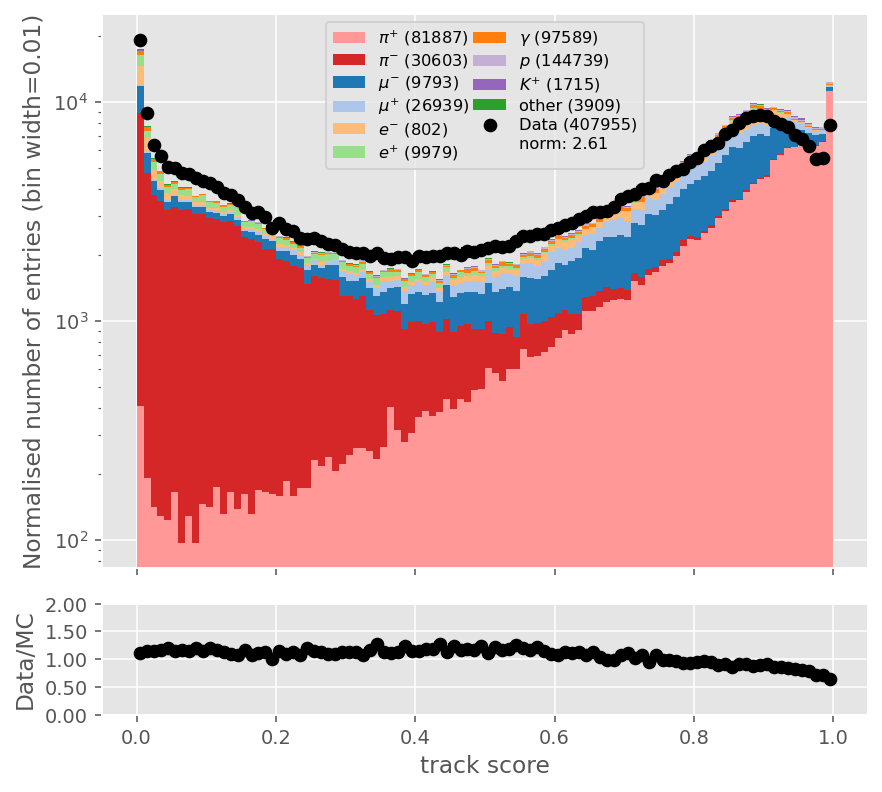

In [4]:
masks = {s : PFOSelection.BeamDaughterCut(samples[s]) for s in samples}
Plots.PlotTagged(samples["mc"].recoParticles.trackScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.trackScore, y_scale = "log", x_label = "track score", norm = True)


number of entries before|after TrackScoreCut: 156355|100379
number of entries before|after TrackScoreCut: 408436|241511


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")


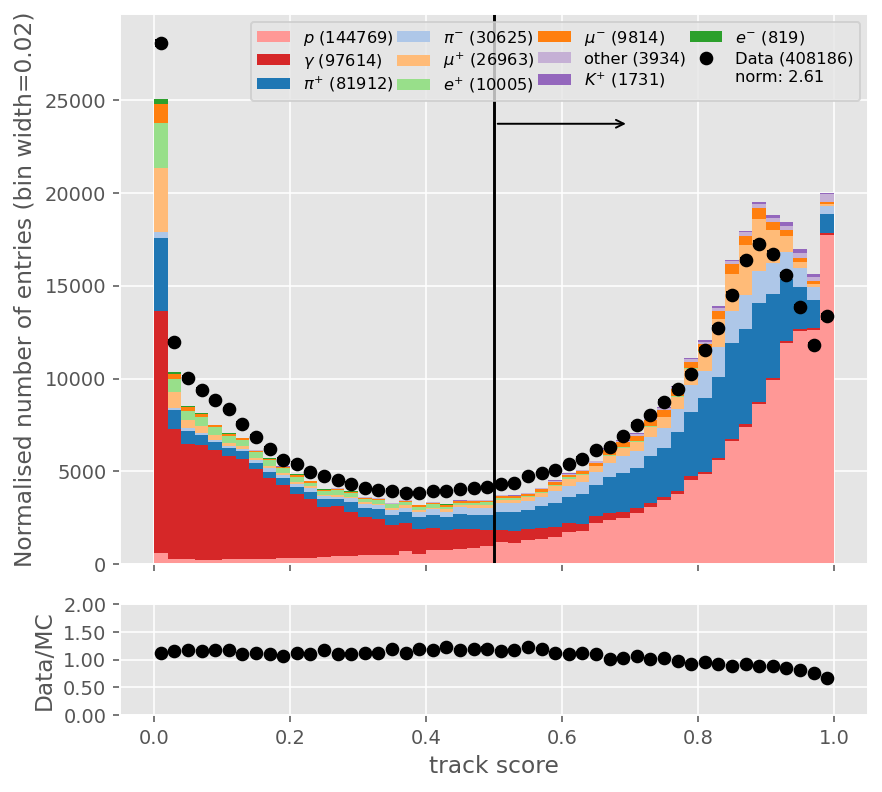

In [11]:
Plots.PlotTagged(samples["mc"].recoParticles.trackScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.trackScore, y_scale = "linear", bins = 50, ncols = 4, x_label = "track score", norm = True)
Plots.DrawCutPosition(0.5, face = "right")

masks = {s : PFOSelection.TrackScoreCut(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after NHitsCut: 100379|94725
number of entries before|after NHitsCut: 241511|227140


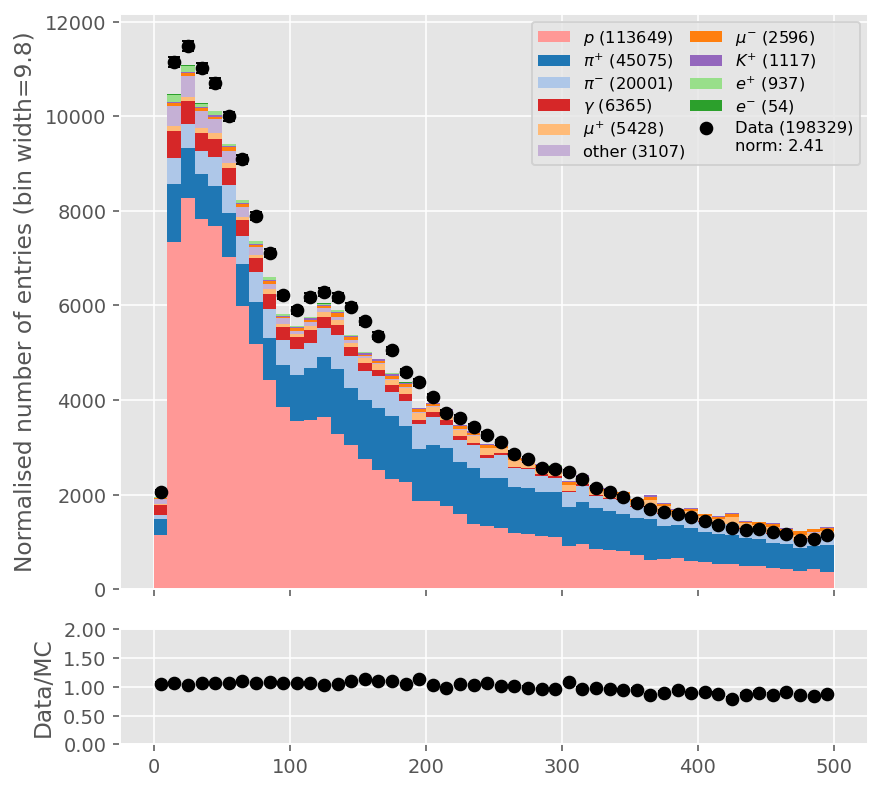

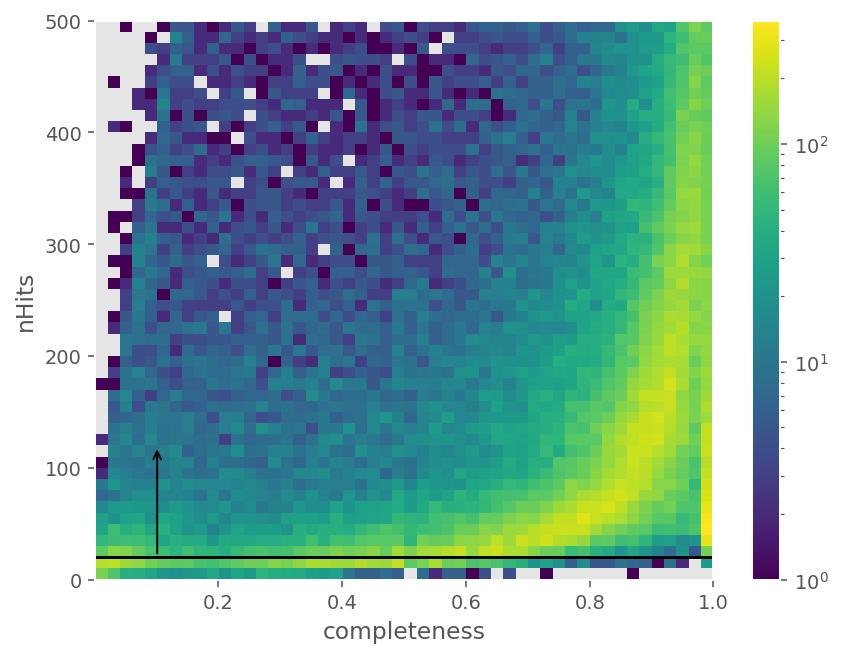

In [14]:
Plots.PlotTagged(samples["mc"].recoParticles.nHits, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.nHits, bins = 50, ncols = 2, x_range = [0, 500], norm = True)
Plots.PlotHist2D(ak.ravel(samples["mc"].trueParticlesBT.completeness), ak.ravel(samples["mc"].recoParticles.nHits), xlabel = "completeness", ylabel = "nHits", y_range = [0, 500], bins = 50)
Plots.DrawCutPosition(20, flip = True, arrow_length = 100, arrow_loc = 0.1)

masks = {s : PFOSelection.NHitsCut(samples[s], 20) for s in samples}
FilterSamples(samples, masks, True)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1130: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1131: RuntimeWarning: invalid value encountered in divide
  ratio_err = ((h_data + p_err) / h_mc) - ratio


number of entries before|after PiPlusSelection: 94725|45586
number of entries before|after PiPlusSelection: 227140|104789


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb1616

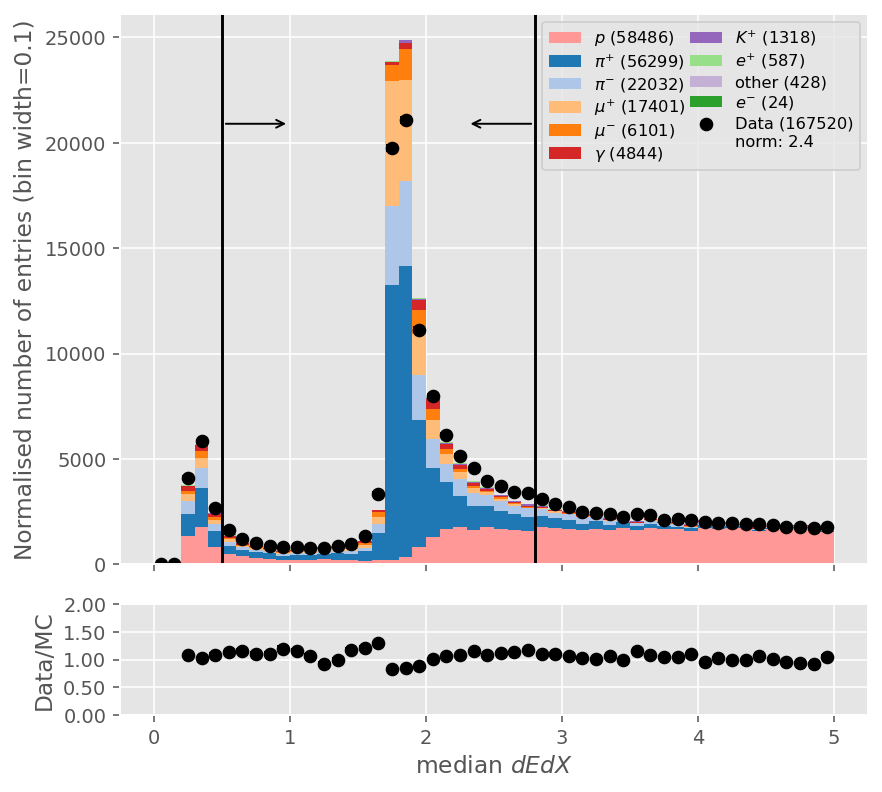

In [21]:
median_dEdX = {s : PFOSelection.Median(samples[s].recoParticles.track_dEdX) for s in samples}
Plots.PlotTagged(median_dEdX["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = median_dEdX["data"], ncols = 2, x_range = [0, 5], x_label = "median $dEdX$", bins = 50, norm = True)

Plots.DrawCutPosition(0.5, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(2.8, arrow_length = 0.5, face = "left")

masks = {s : PFOSelection.PiPlusSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

(['$K^{+}$',
  '$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [310, 1285, 6731, 2205, 20268, 7211, 162, 7, 7337, 70])

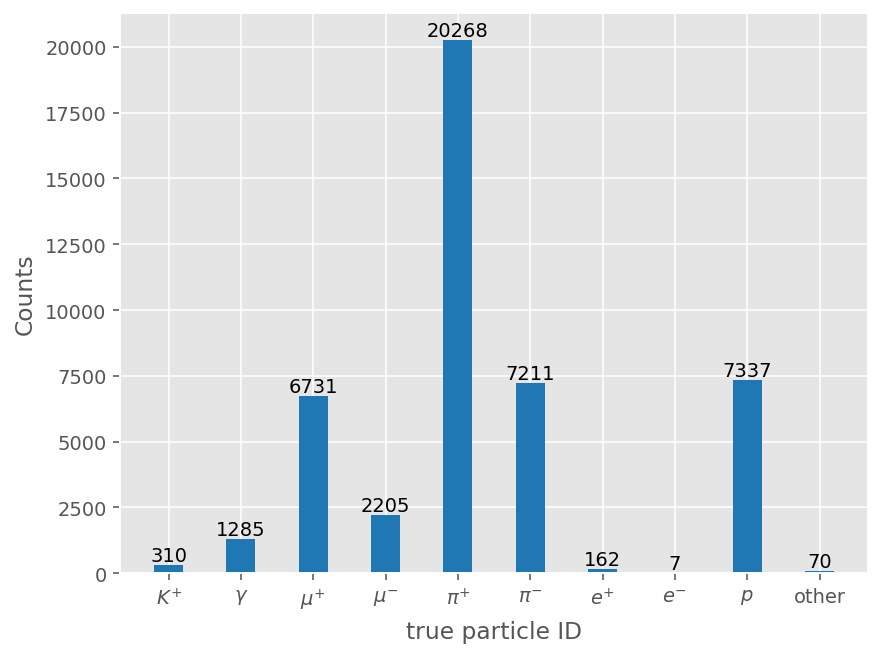

In [22]:
tags = Tags.GenerateTrueParticleTags(samples["mc"])
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag].mask))

Plots.PlotBar(bar_data, xlabel = "true particle ID")


# photon candidate selection

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1130: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1131: RuntimeWarning: invalid value encountered in divide
  ratio_err = ((h_data + p_err) / h_mc) - ratio


number of entries before|after EMScoreCut: 45586|0
number of entries before|after EMScoreCut: 104789|0


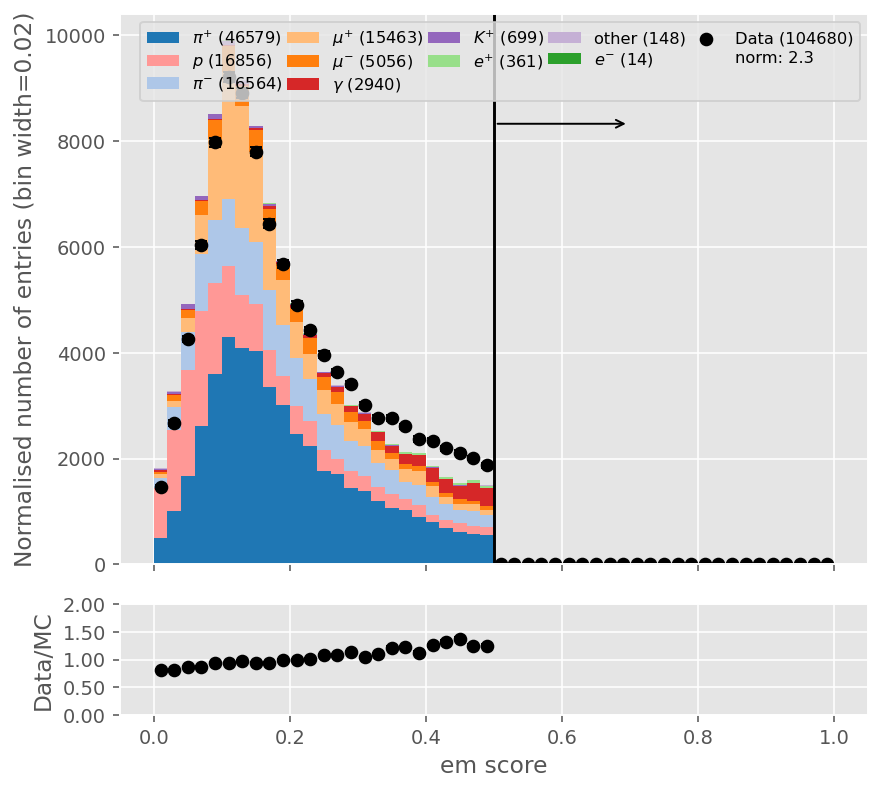

In [23]:
Plots.PlotTagged(samples["mc"].recoParticles.emScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.emScore, bins = 50, x_range = [0, 1], ncols = 5, x_label = "em score", norm = True)
Plots.DrawCutPosition(0.5)

masks = {s : PFOSelection.EMScoreCut(samples[s], 0.5) for s in samples}
FilterSamples(samples, masks, True)

number of entries before|after NHitsCut: 55575|29161
number of entries before|after NHitsCut: 166287|90118


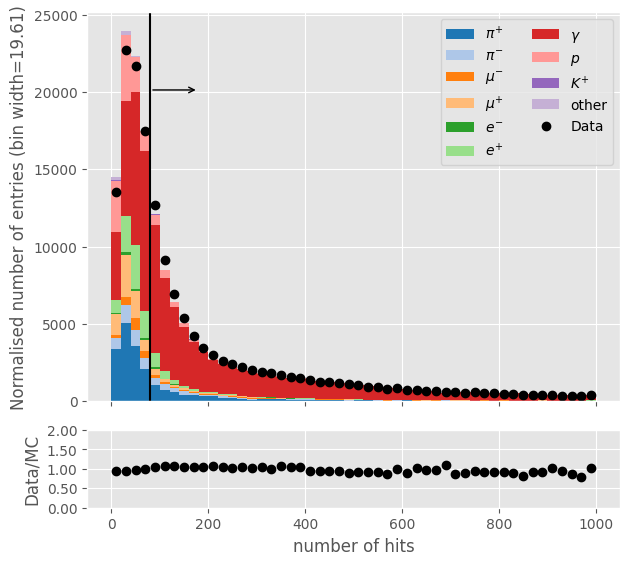

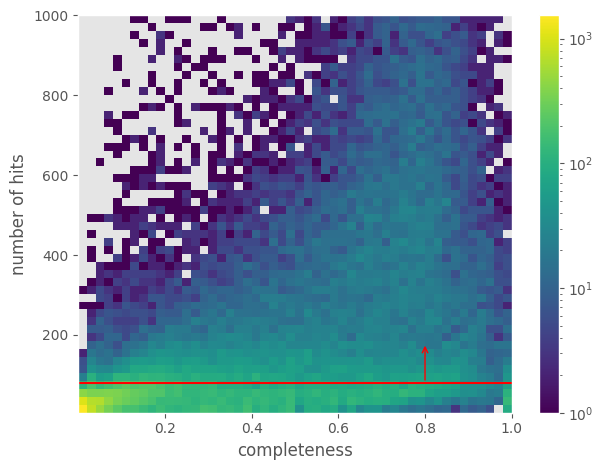

In [6]:
Plots.PlotTagged(samples["mc"].recoParticles.nHits, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.nHits, bins = 50, x_label = "number of hits", x_range = [0, 1000], norm = True)
Plots.DrawCutPosition(80, arrow_length = 100)

Plots.PlotHist2D(ak.ravel(samples["mc"].trueParticlesBT.completeness), ak.ravel(samples["mc"].recoParticles.nHits), bins = 50, x_range = [0, 1],y_range = [0, 1000], xlabel = "completeness", ylabel = "number of hits")
Plots.DrawCutPosition(80, flip = True, arrow_length = 100, color = "red")

masks = {s : PFOSelection.NHitsCut(samples[s], 80) for s in samples}
FilterSamples(samples, masks, True)
# mask = PFOSelection.NHitsCut(events, 80)
# events.Filter([mask])

number of entries before|after BeamParticleDistanceCut: 29161|25642
number of entries before|after BeamParticleDistanceCut: 90118|80621


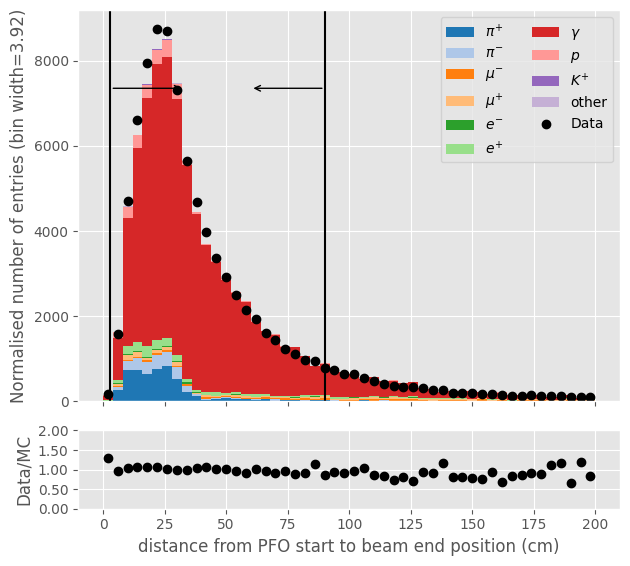

In [7]:
dist = {s : PFOSelection.find_beam_separations(samples[s]) for s in samples}

Plots.PlotTagged(dist["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = dist["data"], bins = 50, x_range = [0, 200], x_label = "distance from PFO start to beam end position (cm)", norm = True)
Plots.DrawCutPosition(3, arrow_length = 30)
Plots.DrawCutPosition(90, face = "left", arrow_length = 30)

masks = {s : PFOSelection.BeamParticleDistanceCut(samples[s], [3, 90]) for s in samples}
FilterSamples(samples, masks, True)

# mask = PFOSelection.BeamParticleDistanceCut(events, [3, 90])
# events.Filter([mask])

number of entries before|after BeamParticleIPCut: 25642|16574
number of entries before|after BeamParticleIPCut: 80621|51943


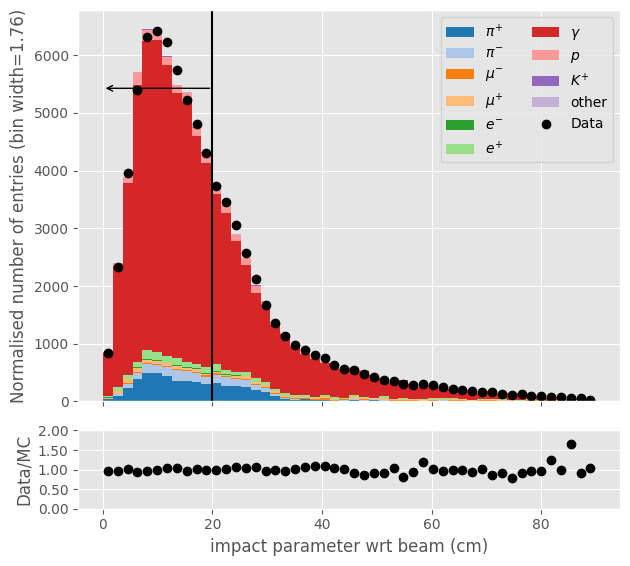

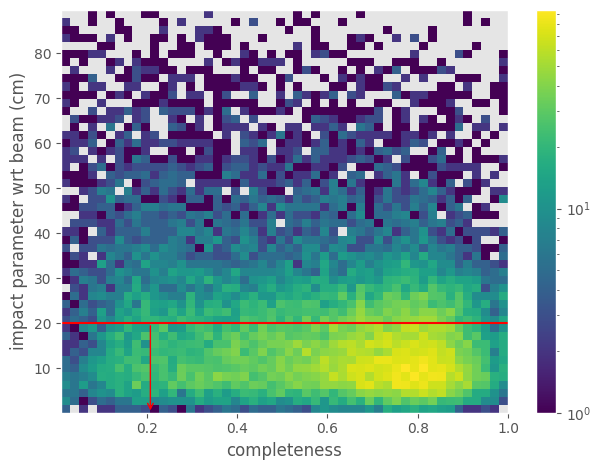

In [8]:
ip = {s : PFOSelection.find_beam_impact_parameters(samples[s]) for s in samples}

Plots.PlotTagged(ip["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = ip["data"], bins = 50, x_label = "impact parameter wrt beam (cm)", norm = True)
Plots.DrawCutPosition(20, arrow_length = 20, face = "left")

Plots.PlotHist2D(ak.ravel(samples["mc"].trueParticlesBT.completeness), ak.ravel(ip["mc"]), bins = 50, x_range = [0, 1], xlabel = "completeness", ylabel = "impact parameter wrt beam (cm)")
Plots.DrawCutPosition(20, arrow_loc = 0.2, arrow_length = 20, face = "left", flip = True, color ="red")

masks = {s : PFOSelection.BeamParticleIPCut(samples[s], 20) for s in samples}
FilterSamples(samples, masks, True)

# mask = PFOSelection.BeamParticleIPCut(events, 20)
# events.Filter([mask])


(['$K^{+}$',
  '$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [13, 13905, 159, 58, 1140, 411, 331, 53, 495, 9])

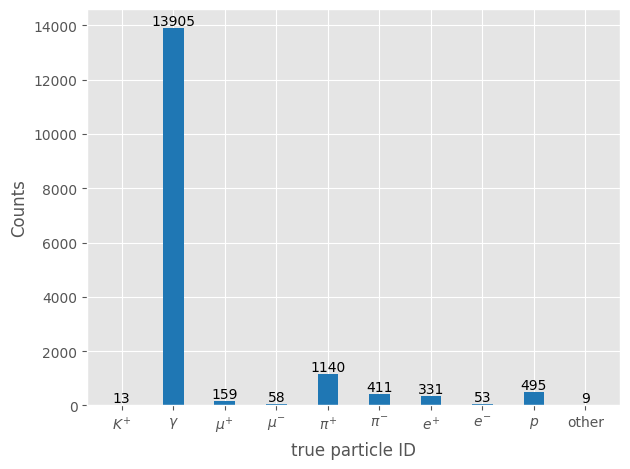

In [9]:
tags = Tags.GenerateTrueParticleTags(samples["mc"])
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag].mask))

Plots.PlotBar(bar_data, xlabel = "true particle ID")

# $\pi^{0}$ selection

In [4]:
photonCandidates = {s : PFOSelection.InitialPi0PhotonSelection(samples[s]) for s in samples}


number of entries before|after EMScoreCut: 155758|55575
number of entries before|after NHitsCut: 155758|100409
number of entries before|after BeamParticleDistanceCut: 155758|138880
number of entries before|after BeamParticleIPCut: 155758|104613
number of entries before|after VetoBeamParticle: 155758|155758
number of entries before|after EMScoreCut: 408436|166287
number of entries before|after NHitsCut: 408436|257758
number of entries before|after BeamParticleDistanceCut: 408436|370077
number of entries before|after BeamParticleIPCut: 408436|277069
number of entries before|after VetoBeamParticle: 408436|408436


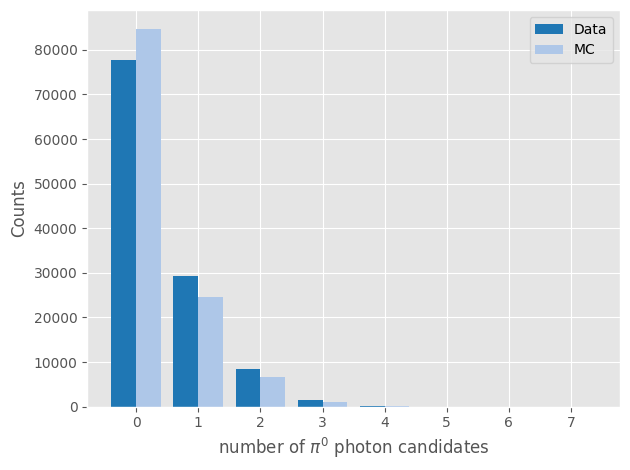

In [5]:
# n_photons = {s : ak.num(samples[s].recoParticles.number) for s in samples}

n_photons = {s : ak.sum(photonCandidates[s], -1) for s in samples}

scale = ak.count(n_photons["data"]) / ak.count(n_photons["mc"])

n_photons_scaled = []
u, c = np.unique(n_photons["mc"], return_counts = True)
for i, j in zip(u, c):
    n_photons_scaled.extend([i]* int(scale * j))

Plots.PlotBarComparision(n_photons_scaled, n_photons["data"], xlabel = "number of $\pi^{0}$ photon candidates", label_1 = "MC", label_2 = "Data")

masks = {s : n_photons[s] == 2 for s in samples}
FilterSamples(samples, masks)
photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

# mask = n_photons == 2
# events.Filter([mask], [mask])

no truth information found, sorting showers by reco energy instead

some tags do not have colours, will override them for the default ones


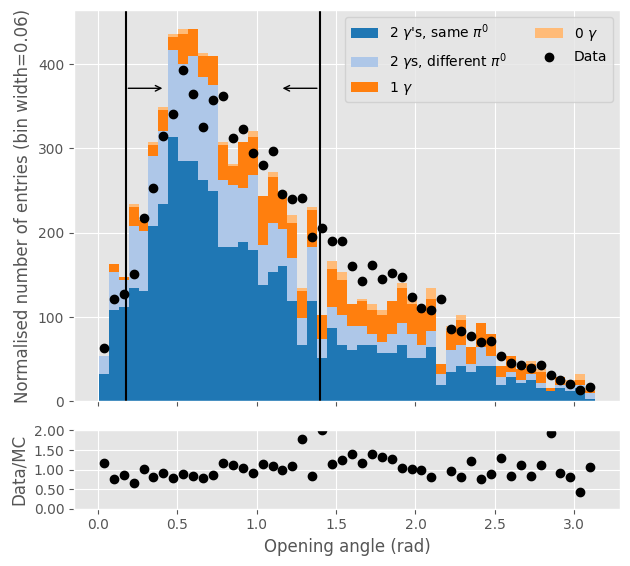

In [6]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

angle = {s : ak.flatten(shower_pairs[s].reco_angle) for s in samples}

Plots.PlotTagged(angle["mc"], Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"]), data2 = angle["data"], bins = 50, x_label = "Opening angle (rad)", norm = True)
Plots.DrawCutPosition(10 * np.pi / 180, face = "right", arrow_length = 0.25)
Plots.DrawCutPosition(80 * np.pi / 180, face = "left", arrow_length = 0.25)

masks = {s : (angle[s] > (10 * np.pi / 180)) & (angle[s] < (80 * np.pi / 180)) for s in samples}
FilterSamples(samples, masks)
photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

no truth information found, sorting showers by reco energy instead

some tags do not have colours, will override them for the default ones


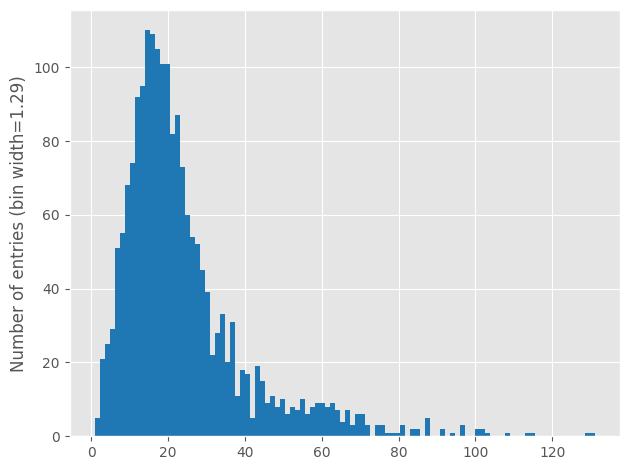

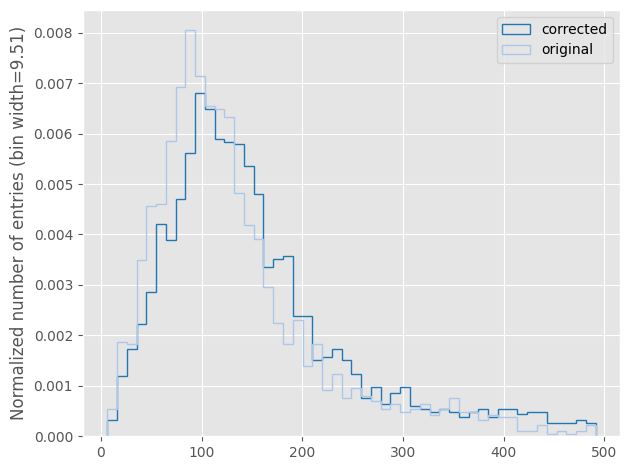

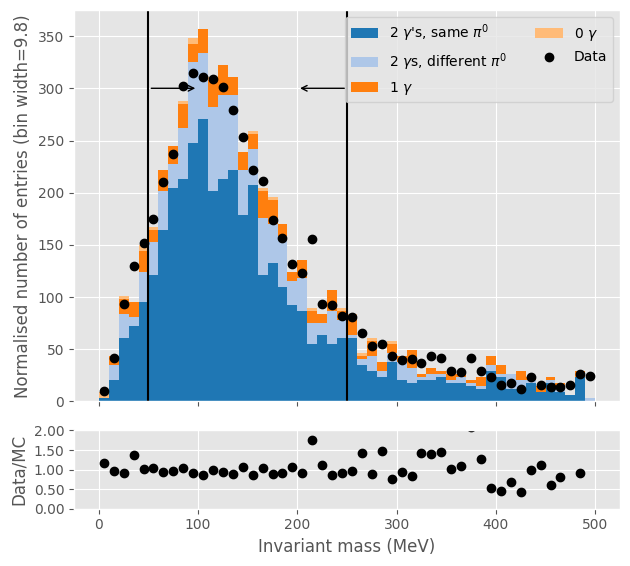

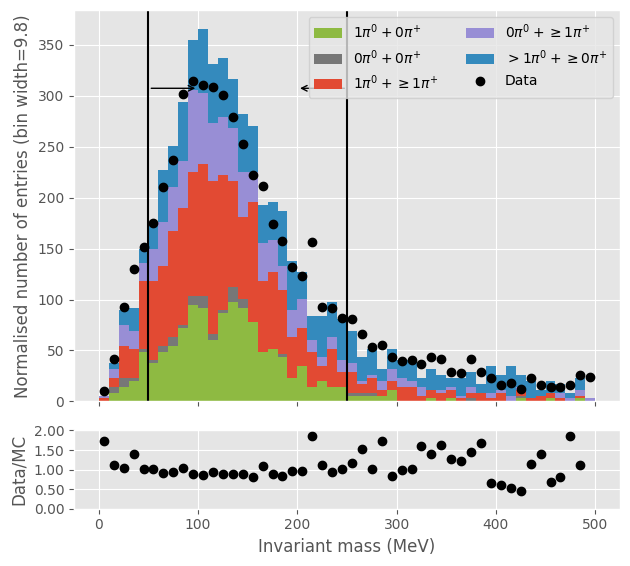

In [18]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

mass = {s : ak.flatten(shower_pairs[s].reco_mass) for s in samples}

f = 0.8528701062421319

Plots.PlotHist((mass["mc"] / f) - mass["mc"])
Plots.PlotHistComparison([mass["mc"] / f, mass["mc"]], labels = ["corrected", "original"], xRange = [0, 500], bins = 50)

Plots.PlotTagged(mass["mc"] / f, Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"]), data2 = mass["data"] / f, bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

Plots.PlotTagged(mass["mc"] / f, Tags.GenerateTrueFinalStateTags(samples["mc"]), data2 = mass["data"] / f, bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

# mask = (mass > 50) & (mass < 250)
# events.Filter([mask], [mask])

In [26]:
event_topology_tags = Tags.GenerateTrueFinalStateTags(samples["mc"])

for t in event_topology_tags:
    print(event_topology_tags[t].name_simple, ak.sum(event_topology_tags[t].mask), ak.count(event_topology_tags[t].mask))

exclusive signal 237 1921

background 350 1921

sideband 312 1921

sideband 904 1921

sideband 118 1921